# Example Notebook for generating some basic analysis plots / fragmentation functions

In [30]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import glue_shower_functions as gsf
from matplotlib.ticker import ScalarFormatter
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

# to use tex in plots
mpl.rcParams.update({"text.usetex": True,"font.family": "sans-serif","font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
mpl.rcParams.update({"text.usetex": True,"font.family": "serif","font.serif": ["Palatino"]})

# Loads dat file with name 'listvarname'
def load_saved_list(listvarname):
    exec('global '+listvarname+'; '+listvarname+' = eval(open(\'dat/'+listvarname+'.dat\').read())')
    
# Returns events with parameters: M0, m0, N, c, d, plasma
# Returns error if cannot find any files with the input parameters
def eventsM0m0cPlasma(M0, m0, N, c, d, plasma):
    compareto = [str(M0), str(m0), str(N), str(c), str(d), str(plasma)]
    filename = [item for item in filenames if [item.replace('point','.').split("_")[index] for index in [2,4,6,8,10,12]] == compareto ]
    return eval(filename[0])[1]

# Returns only final states from a input shower history
def only_final_states(showerhistory):
    return [item for item in showerhistory if item[1] != 'gluon' and item[1] != 'gluon plasma']

# Simply flattens concatenated list into one level
def flatten_list_one_level(inputlist):
    return [item for sublist in inputlist for item in sublist]

# Import data

In [48]:
# Import relevant data from provided input files

glueball_mass_ratios = np.genfromtxt('inputs/glueball_mass_ratios.csv',skip_header=3)
glueballs = np.genfromtxt('inputs/glueball_mass_ratios.csv',skip_header=2, dtype=str)[0][1:]
lambda_scales = np.genfromtxt('inputs/lambda_scales.csv',skip_header=3)
string_tensions = np.genfromtxt('inputs/string_tensions.csv',skip_header=3)

In [3]:
# Add wanted filenames to list that we then load allowing us to call shower histories by filename

filenames = []

M0_range = np.array([ 30, 35, 40, 50, 70, 100, 150, 250, 350, 500, 700, 1000 ])

for i in M0_range:
    filenames.append('showerhistories_M_'+str(i)+'_m0_10_N_3_c_1_d_1_plasma_False_unconstrained_events_15000')
    filenames.append('showerhistories_M_'+str(i)+'_m0_10_N_3_c_2_d_1_plasma_False_unconstrained_events_15000')
    filenames.append('showerhistories_M_'+str(i)+'_m0_10_N_3_c_1_d_2_plasma_False_unconstrained_events_15000')
    filenames.append('showerhistories_M_'+str(i)+'_m0_10_N_3_c_2_d_2_plasma_False_unconstrained_events_15000')

In [4]:
M0_range_plasma = np.array([ 30, 35, 40, 50, 70, 80, 81, 100, 125, 150, 200, 250, 350, 500, 700, 1000 ])

for i in M0_range_plasma:
    filenames.append('showerhistories_M_'+str(i)+'_m0_10_N_3_c_4_d_1_plasma_True_unconstrained_events_15000')
    filenames.append('showerhistories_M_'+str(i)+'_m0_10_N_3_c_6_d_1_plasma_True_unconstrained_events_15000')
    filenames.append('showerhistories_M_'+str(i)+'_m0_10_N_3_c_4_d_2_plasma_True_unconstrained_events_15000')
    filenames.append('showerhistories_M_'+str(i)+'_m0_10_N_3_c_6_d_2_plasma_True_unconstrained_events_15000')

In [35]:
filenames = ['showerhistories_M_100_m0_10_N_3_c_1_d_1_plasma_False_unconstrained_events_100']

In [36]:
for item in filenames:
    load_saved_list(item)

# Example of file structure

In [40]:
# Once files are imported, can simply be called be their name, e.g.

showerhistories_M_100_m0_10_N_3_c_1_d_1_plasma_False_unconstrained_events_100

[{'M': 100,
  'm0': 10,
  'N_c': 3,
  'Lambda_had/2m_0': 1,
  'T_had/T_c': 1,
  'plasma-like': False,
  'nGlueballs': 12,
  'nEvents': 100,
  'unconstrained evolution': True},
 [[[1, '0++', 10.0, [36.667879728076024, 0, 0, 35.27794500467181], 0, []],
   [2,
    'gluon',
    52.6,
    [63.332120271923976, 0, 0, -35.27794500467181],
    0,
    [3, 4]],
   [3,
    '3+-',
    21.4,
    [34.01179418705672,
     -4.931567556176957,
     19.825856490871963,
     -16.776686194386485],
    2,
    []],
   [4,
    '0++',
    10.0,
    [29.320326084867254,
     4.931567556176957,
     -19.825856490871963,
     -18.501258810285325],
    2,
    []]],
  [[1,
    'gluon',
    35.9,
    [55.392437342926826, 0, 0, 42.219363403593725],
    0,
    [3, 4]],
   [2, '2++', 14.4, [44.607562657073174, 0, 0, -42.219363403593725], 0, []],
   [3,
    '1+-',
    17.8,
    [36.027816735696405,
     2.016918767943849,
     5.646550209473268,
     30.744301718470357],
    1,
    []],
   [4,
    '2++',
    14.4,
    [

In [41]:
# First index is the dictionary of shower parameters, e.g.

showerhistories_M_100_m0_10_N_3_c_1_d_1_plasma_False_unconstrained_events_100[0]

{'M': 100,
 'm0': 10,
 'N_c': 3,
 'Lambda_had/2m_0': 1,
 'T_had/T_c': 1,
 'plasma-like': False,
 'nGlueballs': 12,
 'nEvents': 100,
 'unconstrained evolution': True}

In [43]:
# The second index calls the shower histories, e.g.

showerhistories_M_100_m0_10_N_3_c_1_d_1_plasma_False_unconstrained_events_100[1]

# Alternatively can use the eventsM0m0cPlasma(M0, m0, N, c, d, plasma) function to call
# the shower history for the given set of parameters, e.g eventsM0m0cPlasma(100, 10, 3, 1, 1, False)

[[[1, '0++', 10.0, [36.667879728076024, 0, 0, 35.27794500467181], 0, []],
  [2,
   'gluon',
   52.6,
   [63.332120271923976, 0, 0, -35.27794500467181],
   0,
   [3, 4]],
  [3,
   '3+-',
   21.4,
   [34.01179418705672,
    -4.931567556176957,
    19.825856490871963,
    -16.776686194386485],
   2,
   []],
  [4,
   '0++',
   10.0,
   [29.320326084867254,
    4.931567556176957,
    -19.825856490871963,
    -18.501258810285325],
   2,
   []]],
 [[1,
   'gluon',
   35.9,
   [55.392437342926826, 0, 0, 42.219363403593725],
   0,
   [3, 4]],
  [2, '2++', 14.4, [44.607562657073174, 0, 0, -42.219363403593725], 0, []],
  [3,
   '1+-',
   17.8,
   [36.027816735696405,
    2.016918767943849,
    5.646550209473268,
    30.744301718470357],
   1,
   []],
  [4,
   '2++',
   14.4,
   [19.36462060723042,
    -2.016918767943849,
    -5.646550209473268,
    11.475061685123375],
   1,
   []]],
 [[1, 'gluon', 68.0, [70.01228700581488, 0, 0, 16.58840367510403], 0, [3, 4]],
  [2,
   'gluon',
   25.0,
   [29.9

In [46]:
# The shower histories is first indexed by the event number, e.g. this calls the first of 100 events

eventsM0m0cPlasma(100, 10, 3, 1, 1, False)[0]

[[1, '0++', 10.0, [36.667879728076024, 0, 0, 35.27794500467181], 0, []],
 [2, 'gluon', 52.6, [63.332120271923976, 0, 0, -35.27794500467181], 0, [3, 4]],
 [3,
  '3+-',
  21.4,
  [34.01179418705672,
   -4.931567556176957,
   19.825856490871963,
   -16.776686194386485],
  2,
  []],
 [4,
  '0++',
  10.0,
  [29.320326084867254,
   4.931567556176957,
   -19.825856490871963,
   -18.501258810285325],
  2,
  []]]

In [47]:
# And then indexed by the event ID, e.g. this calls the first particle prooduced in the first event

eventsM0m0cPlasma(100, 10, 3, 1, 1, False)[0][0]

[1, '0++', 10.0, [36.667879728076024, 0, 0, 35.27794500467181], 0, []]

In [51]:
# functions such as only_final_states(showerhistory) is helpful for analysis when only interested in the 
# final state glueballs, not the gluons/plasma

glueball_shower_histories = [ only_final_states(showerhistory) for showerhistory in eventsM0m0cPlasma(100, 10, 3, 1, 1, False) ]

# also when not interested in event by event information (such as calculating fragmentation functions)
# flatten_list_one_level(inputlist) is helpful for just outputing a single list of all glueballs for example

flatten_list_one_level(glueball_shower_histories)

[1, '0++', 10.0, [36.667879728076024, 0, 0, 35.27794500467181], 0, []]

# Average multiplicity analysis

In [11]:
# For given set of parameters, functions return the total and 0++ glueball average multiplicity 

def average_N(M0,m0,N,c,d,plasma):
    values = np.array([len(only_final_states(item)) for item in eventsM0m0cPlasma(M0,m0,N,c,d,plasma)])
    return np.mean(values), np.percentile(values,16), np.percentile(values,84)

def average_N_0pp(M0,m0,N,c,d,plasma):
    final_states = [(only_final_states(item)) for item in eventsM0m0cPlasma(M0,m0,N,c,d,plasma)]
    values = [ len([j for j in i if j[1] == '0++' ]) for i in final_states]
    return np.mean(values), np.percentile(values,16), np.percentile(values,84)

## Varying centre of mass energy

In [12]:
## alpha of the mirror sector to three loop accuracy, as given in https://arxiv.org/pdf/hep-ph/0607209.pdf

def alpha_mirror_N(mu,mg,N,lambda_ratio):
    beta0 = (11/3)*N
    beta1 = (34/3)*N**2
    beta2 = 2857/2
    scale = mg/lambda_ratio
    L = 2*np.log(mu/scale)

    term2 = beta1*np.log(L)/(beta0**2 * L**2)
    term3 = beta1**2*(np.log(L)**2 - np.log(L) - 1)/(beta0**4 * L**3) + beta2/(beta0**3 * L**3)
    
    return (4*math.pi/beta0)*(1/L - term2 + term3)

alpha_mirror_N_vec = np.vectorize(alpha_mirror_N)

In [13]:
# Analytically expected multiplicity as listed in our paper
# 'norm' = Multiplicity value to normalise function to at M value 'normx'

def NGB_analytical(x,m0,N,norm,normx):
    lambda_ratio = lambda_scales[np.where(lambda_scales == N)[0][0]][1]
    b = 11*N/(12*np.pi)
    val = np.exp((1/b)*np.sqrt(2*N/(np.pi*alpha_mirror_N(normx,m0,N,lambda_ratio))) + 0.25*np.log(alpha_mirror_N(normx,m0,N,lambda_ratio)))
    return np.exp((1/b)*np.sqrt(2*N/(np.pi*alpha_mirror_N(x,m0,N,lambda_ratio))) + 0.25*np.log(alpha_mirror_N(x,m0,N,lambda_ratio))) * norm/val

NGB_analytical_vec = np.vectorize(NGB_analytical)

In [14]:
avgN_N3_c1_d1 = np.array([ average_N(i,10,3,1,1,False)[0] for i in M0_range ])
avgN_N3_c1_d1_err_upper = np.array([ average_N(i,10,3,1,1,False)[2] for i in M0_range ])
avgN_N3_c1_d1_err_lower = np.array([ average_N(i,10,3,1,1,False)[1] for i in M0_range ])

avgN_N3_c1_d2 = np.array([ average_N(i,10,3,1,2,False)[0] for i in M0_range ])
avgN_N3_c1_d2_err_upper = np.array([ average_N(i,10,3,1,2,False)[2] for i in M0_range ])
avgN_N3_c1_d2_err_lower = np.array([ average_N(i,10,3,1,2,False)[1] for i in M0_range ])

avgN_N3_c2_d1 = np.array([ average_N(i,10,3,2,1,False)[0] for i in M0_range ])
avgN_N3_c2_d1_err_upper = np.array([ average_N(i,10,3,2,1,False)[2] for i in M0_range ])
avgN_N3_c2_d1_err_lower = np.array([ average_N(i,10,3,2,1,False)[1] for i in M0_range ])

avgN_N3_c2_d2 = np.array([ average_N(i,10,3,2,2,False)[0] for i in M0_range ])
avgN_N3_c2_d2_err_upper = np.array([ average_N(i,10,3,2,2,False)[2] for i in M0_range ])
avgN_N3_c2_d2_err_lower = np.array([ average_N(i,10,3,2,2,False)[1] for i in M0_range ])

avgN_N3_c4_d1_plasma = np.array([ average_N(i,10,3,4,1,True)[0] for i in M0_range_plasma ])
avgN_N3_c4_d1_plasma_err_upper = np.array([ average_N(i,10,3,4,1,True)[2] for i in M0_range_plasma ])
avgN_N3_c4_d1_plasma_err_lower = np.array([ average_N(i,10,3,4,1,True)[1] for i in M0_range_plasma ])

avgN_N3_c4_d2_plasma = np.array([ average_N(i,10,3,4,2,True)[0] for i in M0_range_plasma ])
avgN_N3_c4_d2_plasma_err_upper = np.array([ average_N(i,10,3,4,2,True)[2] for i in M0_range_plasma ])
avgN_N3_c4_d2_plasma_err_lower = np.array([ average_N(i,10,3,4,2,True)[1] for i in M0_range_plasma ])

avgN_N3_c6_d1_plasma = np.array([ average_N(i,10,3,6,1,True)[0] for i in M0_range_plasma ])
avgN_N3_c6_d1_plasma_err_upper = np.array([ average_N(i,10,3,6,1,True)[2] for i in M0_range_plasma ])
avgN_N3_c6_d1_plasma_err_lower = np.array([ average_N(i,10,3,6,1,True)[1] for i in M0_range_plasma ])

avgN_N3_c6_d2_plasma = np.array([ average_N(i,10,3,6,2,True)[0] for i in M0_range_plasma ])
avgN_N3_c6_d2_plasma_err_upper = np.array([ average_N(i,10,3,6,2,True)[2] for i in M0_range_plasma ])
avgN_N3_c6_d2_plasma_err_lower = np.array([ average_N(i,10,3,6,2,True)[1] for i in M0_range_plasma ])

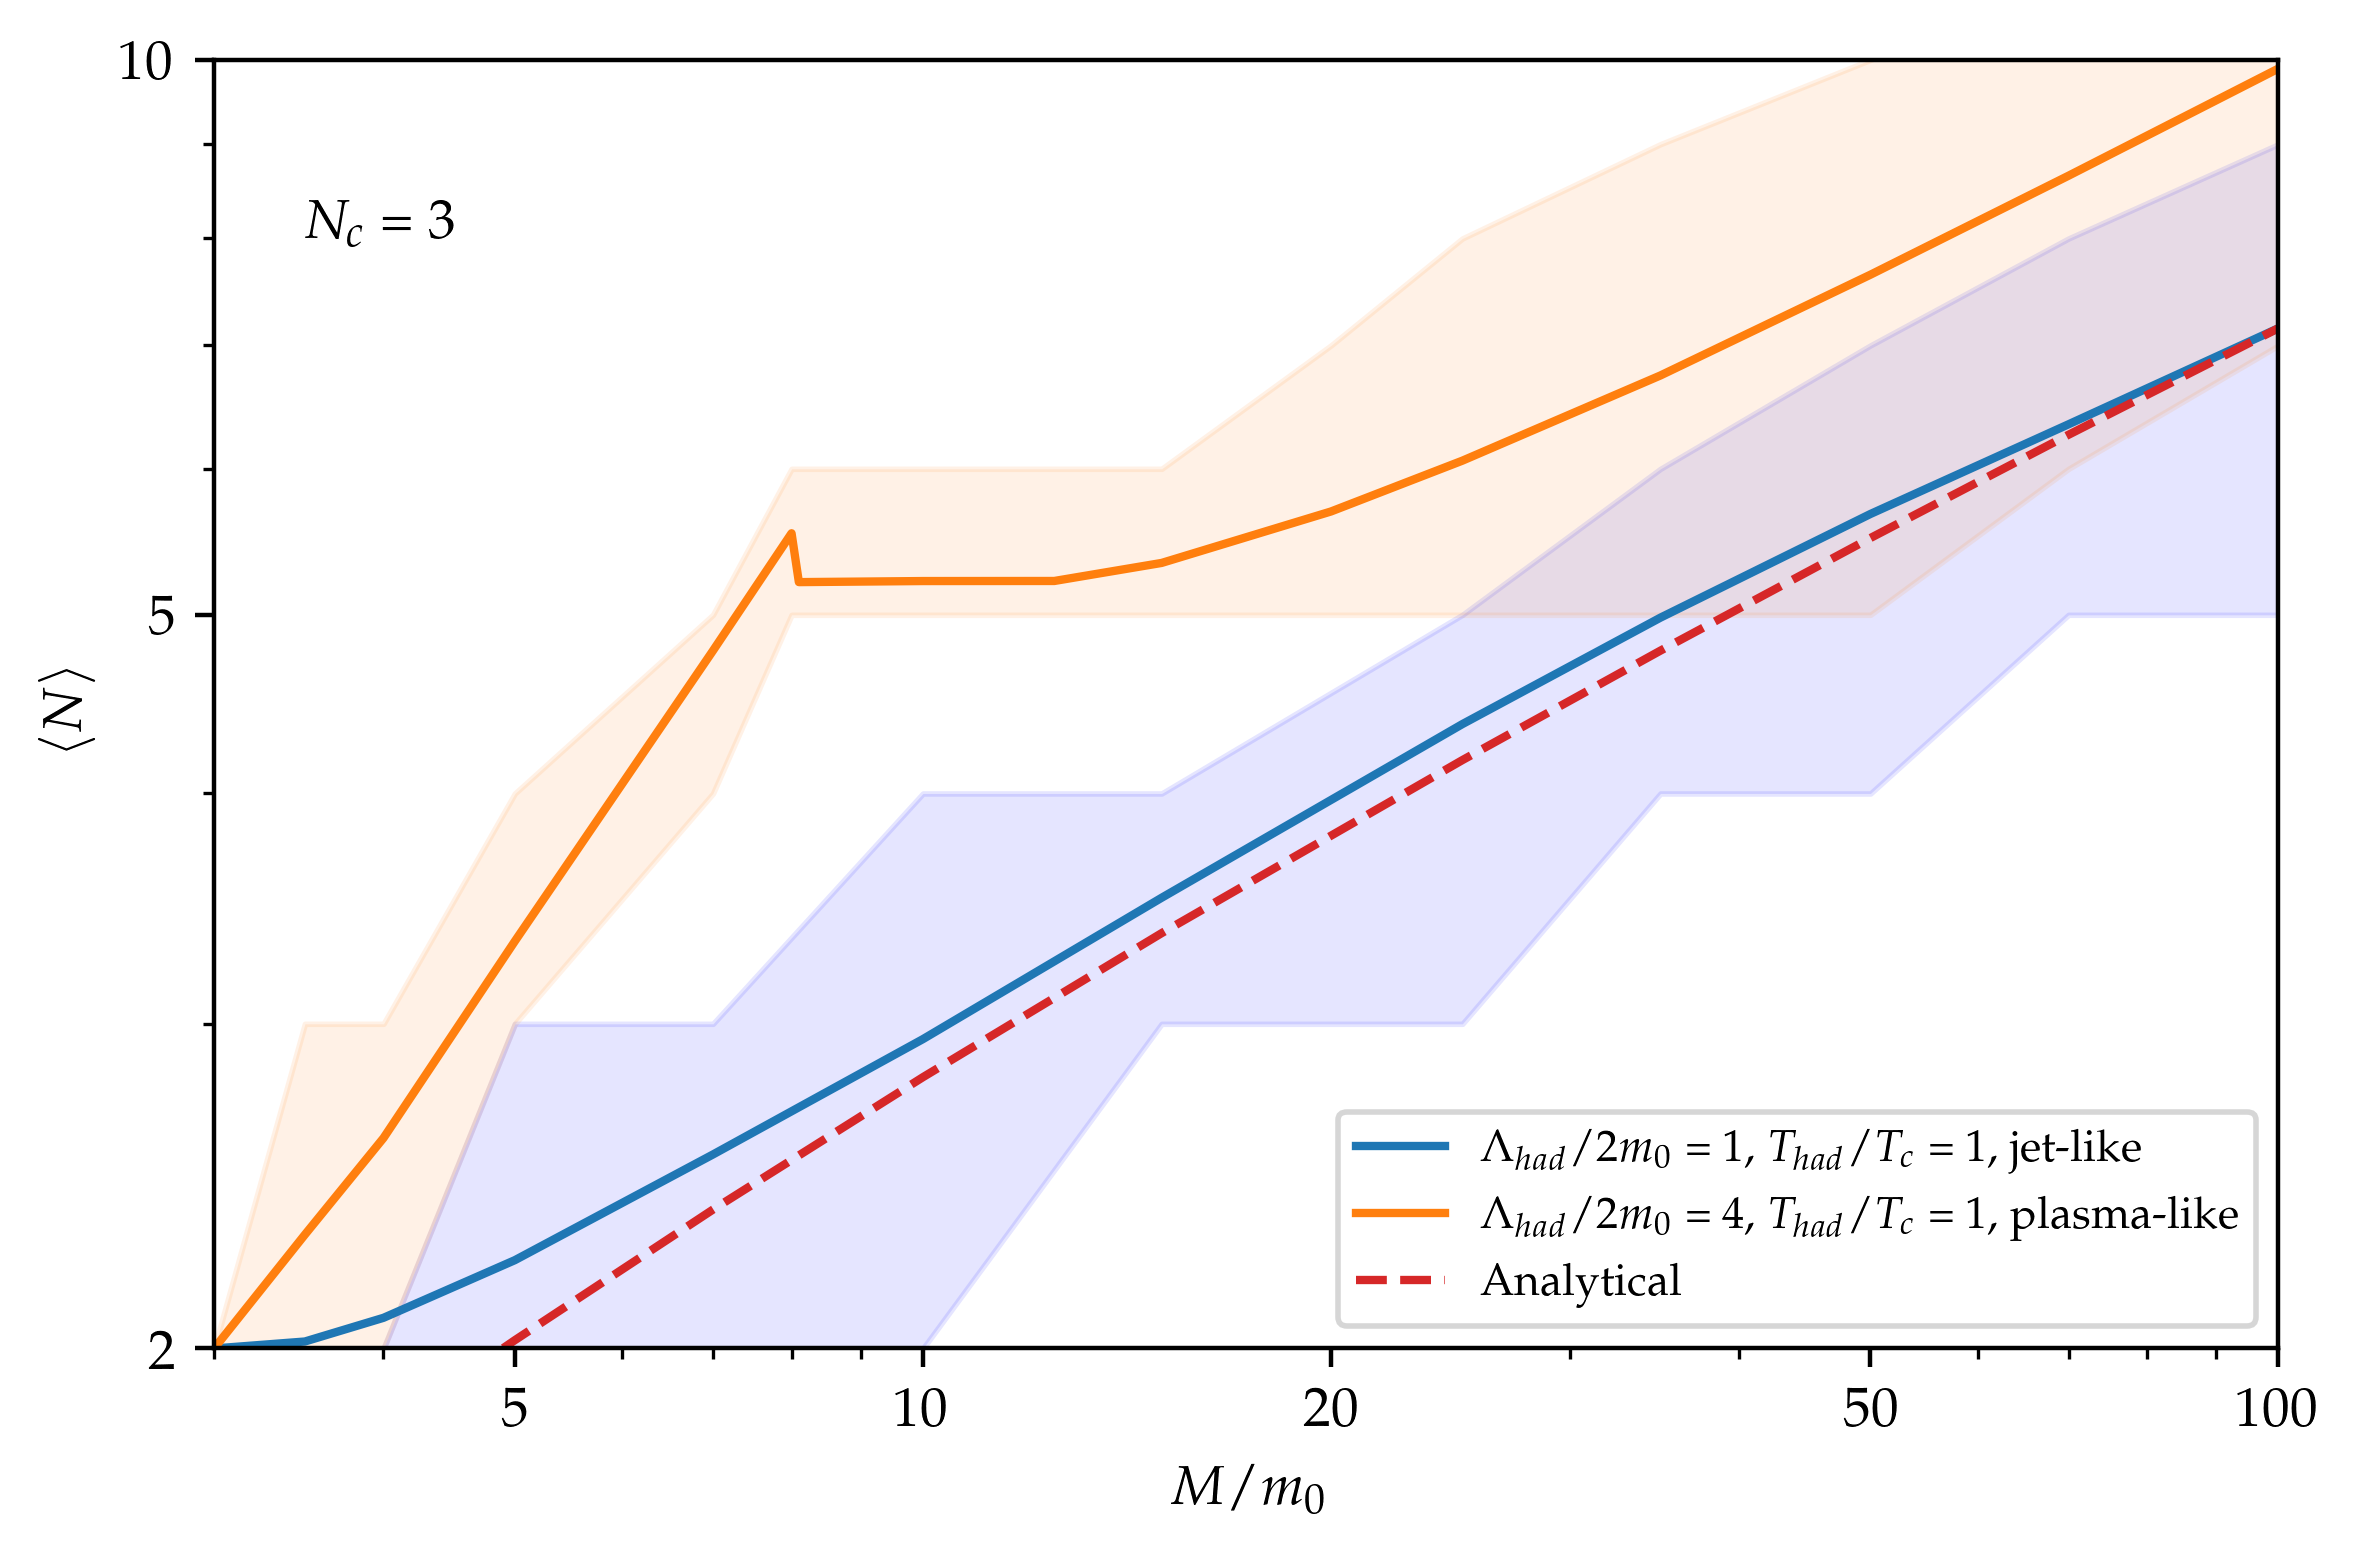

In [16]:
interp_N3_c1_d1 = lambda x : interp1d(M0_range,avgN_N3_c1_d1)(x)

mscale = M0_range[-1]
m0 = 10

fig, ax = plt.subplots(figsize=(6,4),dpi=400)

ax.plot(M0_range/m0, avgN_N3_c1_d1,label = "$\Lambda_{had}/2m_0$ = 1, $T_{had}/T_c$ = 1, jet-like", color = "tab:blue")
ax.fill_between(M0_range/m0, avgN_N3_c1_d1_err_lower, avgN_N3_c1_d1_err_upper, color='b', alpha=.1)

ax.plot(M0_range_plasma/m0, avgN_N3_c4_d1_plasma, label = "$\Lambda_{had}/2m_0$ = 4, $T_{had}/T_c$ = 1, plasma-like",
        color = "tab:orange")
ax.fill_between(M0_range_plasma/m0, avgN_N3_c4_d1_plasma_err_lower, avgN_N3_c4_d1_plasma_err_upper, color='tab:orange', alpha=.1)

ax.plot(M0_range/m0, NGB_analytical_vec(M0_range, 10, 3, interp_N3_c1_d1(mscale), mscale),
        color = "tab:red",linestyle = "dashed", label = "Analytical")


#ax.set_title("Average Glueball Multiplicity")
ax.legend(loc='lower right', prop={'size': 8})
ax.set_ylabel("$\langle N \\rangle $")
ax.set_xlabel('$M / m_0$')
plt.xlim([3,100])
plt.ylim([2,10])
ax.set_xscale('log')
ax.set_yscale('log')

ax.text(3.5, 8, '$N_c$ = 3', fontsize = 10)

ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False)) # get rid of ridiculous offset
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False)) # get rid of ridiculous offset

ax.set_xticks([5,10,20,50,100])
ax.set_yticks([2,5,10])
plt.setp(ax.get_yminorticklabels(), visible=False)

fig.patch.set_facecolor('white')
fig.tight_layout()

plt.savefig('plots/analytical_multiplicity.pdf',bbox_inches='tight')

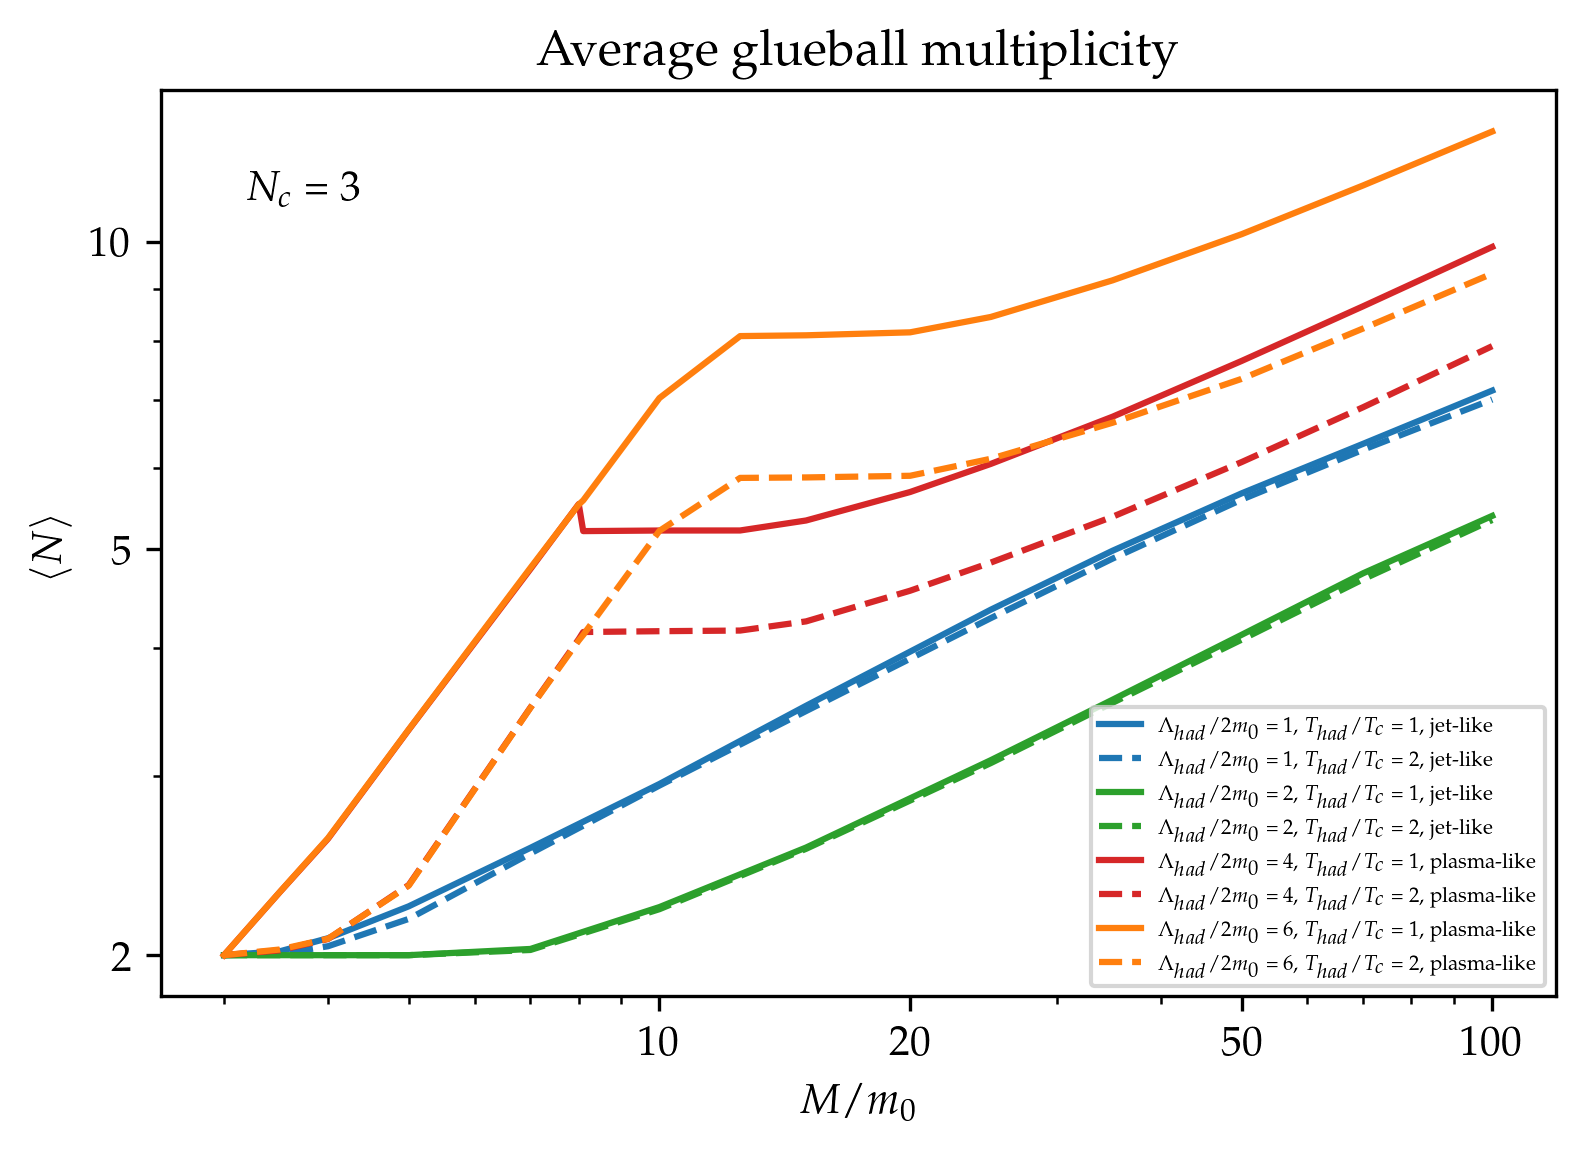

In [18]:
fig, ax = plt.subplots(figsize=(6,4),dpi=300)

ax.plot(M0_range/m0, avgN_N3_c1_d1, label = "$\Lambda_{had}/2m_0$ = 1, $T_{had}/T_c$ = 1, jet-like", color = "tab:blue")
ax.plot(M0_range/m0, avgN_N3_c1_d2, label = "$\Lambda_{had}/2m_0$ = 1, $T_{had}/T_c$ = 2, jet-like", color = "tab:blue",
        linestyle = 'dashed')

ax.plot(M0_range/m0, avgN_N3_c2_d1, label = "$\Lambda_{had}/2m_0$ = 2, $T_{had}/T_c$ = 1, jet-like", color = "tab:green")
ax.plot(M0_range/m0, avgN_N3_c2_d2, label = "$\Lambda_{had}/2m_0$ = 2, $T_{had}/T_c$ = 2, jet-like", color = "tab:green",
        linestyle = 'dashed')

ax.plot(M0_range_plasma/m0, avgN_N3_c4_d1_plasma, label = "$\Lambda_{had}/2m_0$ = 4, $T_{had}/T_c$ = 1, plasma-like", color = "tab:red")
ax.plot(M0_range_plasma/m0, avgN_N3_c4_d2_plasma,label = "$\Lambda_{had}/2m_0$ = 4, $T_{had}/T_c$ = 2, plasma-like", color = "tab:red",
        linestyle = 'dashed')

ax.plot(M0_range_plasma/m0, avgN_N3_c6_d1_plasma,label = "$\Lambda_{had}/2m_0$ = 6, $T_{had}/T_c$ = 1, plasma-like", color = "tab:orange")
ax.plot(M0_range_plasma/m0, avgN_N3_c6_d2_plasma,label = "$\Lambda_{had}/2m_0$ = 6, $T_{had}/T_c$ = 2, plasma-like", color = "tab:orange",
        linestyle = 'dashed')

ax.set_title("Average glueball multiplicity")
ax.legend(loc='lower right', prop={'size': 5})
ax.set_ylabel("$\langle N \\rangle $")
ax.set_xlabel('$M / m_0$')

ax.text(3.2, 11, '$N_c$ = 3', fontsize = 10)

ax.set_xscale('log')
ax.set_yscale('log')

ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False)) # get rid of ridiculous offset
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False)) # get rid of ridiculous offset

ax.set_xticks([10,20,50,100])
ax.set_yticks([2,5,10])
plt.setp(ax.get_yminorticklabels(), visible=False)

fig.patch.set_facecolor('white')
#fig.tight_layout()

plt.savefig('plots/benchmark_multiplicity.pdf',bbox_inches='tight')

In [19]:
avgN_0pp_N3_c1_d1 = np.array([ average_N_0pp(i,10,3,1,1,False)[0] for i in M0_range ])
avgN_0pp_N3_c1_d1_err_upper = np.array([ average_N_0pp(i,10,3,1,1,False)[2] for i in M0_range ])
avgN_0pp_N3_c1_d1_err_lower = np.array([ average_N_0pp(i,10,3,1,1,False)[1] for i in M0_range ])

avgN_0pp_N3_c1_d2 = np.array([ average_N_0pp(i,10,3,1,2,False)[0] for i in M0_range ])
avgN_0pp_N3_c1_d2_err_upper = np.array([ average_N_0pp(i,10,3,1,2,False)[2] for i in M0_range ])
avgN_0pp_N3_c1_d2_err_lower = np.array([ average_N_0pp(i,10,3,1,2,False)[1] for i in M0_range ])

avgN_0pp_N3_c2_d1 = np.array([ average_N_0pp(i,10,3,2,1,False)[0] for i in M0_range ])
avgN_0pp_N3_c2_d1_err_upper = np.array([ average_N_0pp(i,10,3,2,1,False)[2] for i in M0_range ])
avgN_0pp_N3_c2_d1_err_lower = np.array([ average_N_0pp(i,10,3,2,1,False)[1] for i in M0_range ])

avgN_0pp_N3_c2_d2 = np.array([ average_N_0pp(i,10,3,2,2,False)[0] for i in M0_range ])
avgN_0pp_N3_c2_d2_err_upper = np.array([ average_N_0pp(i,10,3,2,2,False)[2] for i in M0_range ])
avgN_0pp_N3_c2_d2_err_lower = np.array([ average_N_0pp(i,10,3,2,2,False)[1] for i in M0_range ])

avgN_0pp_N3_c4_d1_plasma = np.array([ average_N_0pp(i,10,3,4,1,True)[0] for i in M0_range_plasma ])
avgN_0pp_N3_c4_d1_plasma_err_upper = np.array([ average_N_0pp(i,10,3,4,1,True)[2] for i in M0_range_plasma ])
avgN_0pp_N3_c4_d1_plasma_err_lower = np.array([ average_N_0pp(i,10,3,4,1,True)[1] for i in M0_range_plasma ])

avgN_0pp_N3_c4_d2_plasma = np.array([ average_N_0pp(i,10,3,4,2,True)[0] for i in M0_range_plasma ])
avgN_0pp_N3_c4_d2_plasma_err_upper = np.array([ average_N_0pp(i,10,3,4,2,True)[2] for i in M0_range_plasma ])
avgN_0pp_N3_c4_d2_plasma_err_lower = np.array([ average_N_0pp(i,10,3,4,2,True)[1] for i in M0_range_plasma ])

avgN_0pp_N3_c6_d1_plasma = np.array([ average_N_0pp(i,10,3,6,1,True)[0] for i in M0_range_plasma ])
avgN_0pp_N3_c6_d1_plasma_err_upper = np.array([ average_N_0pp(i,10,3,6,1,True)[2] for i in M0_range_plasma ])
avgN_0pp_N3_c6_d1_plasma_err_lower = np.array([ average_N_0pp(i,10,3,6,1,True)[1] for i in M0_range_plasma ])

avgN_0pp_N3_c6_d2_plasma = np.array([ average_N_0pp(i,10,3,6,2,True)[0] for i in M0_range_plasma ])
avgN_0pp_N3_c6_d2_plasma_err_upper = np.array([ average_N_0pp(i,10,3,6,2,True)[2] for i in M0_range_plasma ])
avgN_0pp_N3_c6_d2_plasma_err_lower = np.array([ average_N_0pp(i,10,3,6,2,True)[1] for i in M0_range_plasma ])

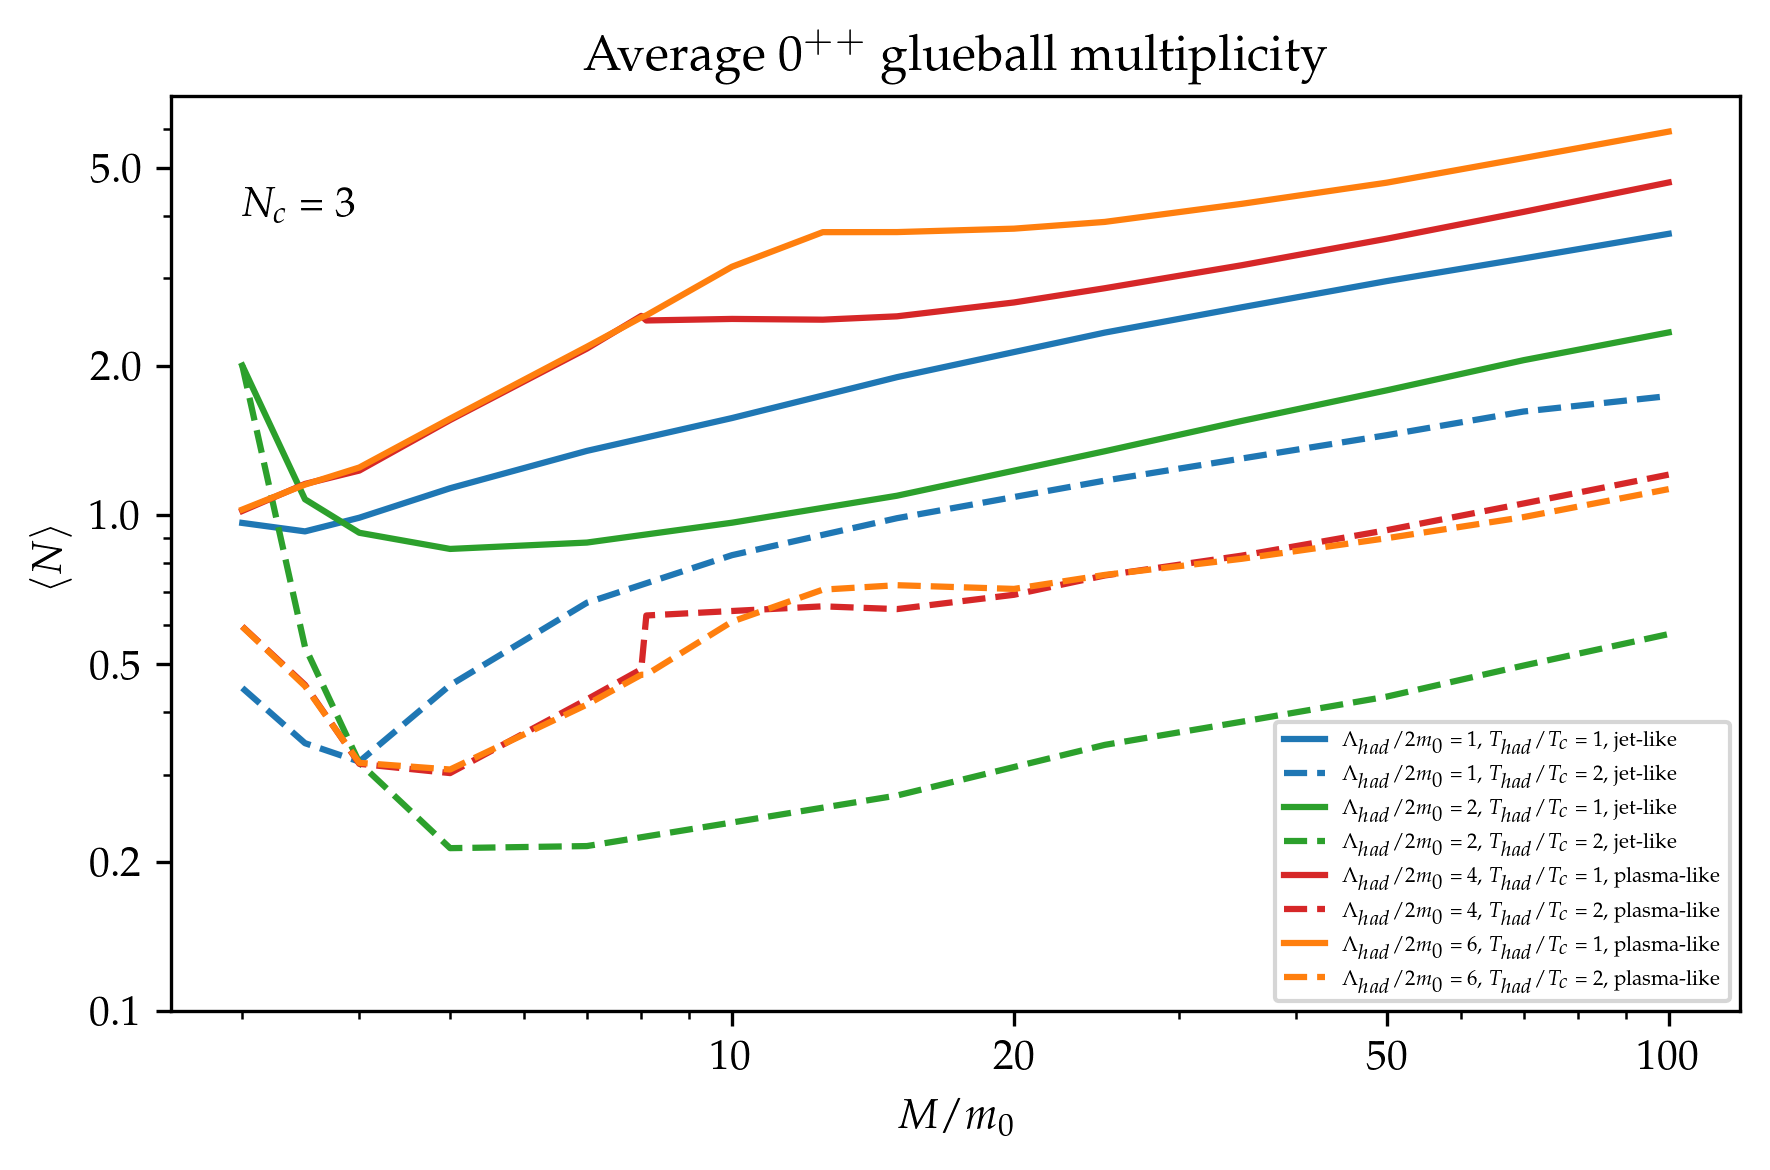

In [20]:
mscale = M0_range[-1]

fig, ax = plt.subplots(figsize=(6,4),dpi=300)

ax.plot(M0_range/m0, avgN_0pp_N3_c1_d1, label = "$\Lambda_{had}/2m_0$ = 1, $T_{had}/T_c$ = 1, jet-like", color = "tab:blue")
ax.plot(M0_range/m0, avgN_0pp_N3_c1_d2, label = "$\Lambda_{had}/2m_0$ = 1, $T_{had}/T_c$ = 2, jet-like", color = "tab:blue",
        linestyle = 'dashed')

ax.plot(M0_range/m0, avgN_0pp_N3_c2_d1, label = "$\Lambda_{had}/2m_0$ = 2, $T_{had}/T_c$ = 1, jet-like", color = "tab:green")
ax.plot(M0_range/m0, avgN_0pp_N3_c2_d2,label = "$\Lambda_{had}/2m_0$ = 2, $T_{had}/T_c$ = 2, jet-like", color = "tab:green",
        linestyle = 'dashed')

ax.plot(M0_range_plasma/m0, avgN_0pp_N3_c4_d1_plasma,label = "$\Lambda_{had}/2m_0$ = 4, $T_{had}/T_c$ = 1, plasma-like", color = "tab:red")
ax.plot(M0_range_plasma/m0, avgN_0pp_N3_c4_d2_plasma,label = "$\Lambda_{had}/2m_0$ = 4, $T_{had}/T_c$ = 2, plasma-like", color = "tab:red",
        linestyle = 'dashed')

ax.plot(M0_range_plasma/m0, avgN_0pp_N3_c6_d1_plasma, label = "$\Lambda_{had}/2m_0$ = 6, $T_{had}/T_c$ = 1, plasma-like", color = "tab:orange")
ax.plot(M0_range_plasma/m0, avgN_0pp_N3_c6_d2_plasma,label = "$\Lambda_{had}/2m_0$ = 6, $T_{had}/T_c$ = 2, plasma-like", color = "tab:orange",
        linestyle = 'dashed')

ax.set_title("Average $0^{++}$ glueball multiplicity")
ax.legend(loc='lower right', prop={'size': 5})
ax.set_ylabel("$\langle N \\rangle $")
ax.set_xlabel('$M / m_0$')
ax.set_xscale('log')
ax.set_yscale('log')

ax.text(3, 4, '$N_c$ = 3', fontsize = 10)

#ax.set_xlim(xmin=5, xmax=100)
#ax.set_ylim(ymin=0.1, ymax=6)

ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False)) # get rid of ridiculous offset
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False)) # get rid of ridiculous offset

ax.set_xticks([10,20,50,100])
ax.set_yticks([0.1,0.2,0.5,1,2,5])
plt.setp(ax.get_yminorticklabels(), visible=False)

fig.patch.set_facecolor('white')
fig.tight_layout()

plt.savefig('plots/benchmark_multiplicity_0pp.pdf',bbox_inches='tight')

# Average Energy Analysis

In [21]:
def average_E(M0,m0,N,c,d,plasma):
    glueballs = flatten_list_one_level([ only_final_states(item) for item in eventsM0m0cPlasma(M0,m0,N,c,d,plasma)])
    values = [ i[3][0] for i in glueballs ]
    return np.mean(values), np.percentile(values,16), np.percentile(values,84)

def average_E_0pp(M0,m0,N,c,d,plasma):
    glueballs = flatten_list_one_level([ only_final_states(item) for item in eventsM0m0cPlasma(M0,m0,N,c,d,plasma)])
    values = [ i[3][0] for i in glueballs if i[1] == '0++' ]
    return np.mean(values), np.percentile(values,16), np.percentile(values,84)

## Varying centre of mass energy

In [22]:
avgE_N3_c1_d1 = np.array([ average_E(i,10,3,1,1,False)[0] for i in M0_range ])
avgE_N3_c1_d1_err_upper = np.array([ average_E(i,10,3,1,1,False)[2] for i in M0_range ])
avgE_N3_c1_d1_err_lower = np.array([ average_E(i,10,3,1,1,False)[1] for i in M0_range ])

avgE_N3_c1_d2 = np.array([ average_E(i,10,3,1,2,False)[0] for i in M0_range ])
avgE_N3_c1_d2_err_upper = np.array([ average_E(i,10,3,1,2,False)[2] for i in M0_range ])
avgE_N3_c1_d2_err_lower = np.array([ average_E(i,10,3,1,2,False)[1] for i in M0_range ])

avgE_N3_c2_d1 = np.array([ average_E(i,10,3,2,1,False)[0] for i in M0_range ])
avgE_N3_c2_d1_err_upper = np.array([ average_E(i,10,3,2,1,False)[2] for i in M0_range ])
avgE_N3_c2_d1_err_lower = np.array([ average_E(i,10,3,2,1,False)[1] for i in M0_range ])

avgE_N3_c2_d2 = np.array([ average_E(i,10,3,2,2,False)[0] for i in M0_range ])
avgE_N3_c2_d2_err_upper = np.array([ average_E(i,10,3,2,2,False)[2] for i in M0_range ])
avgE_N3_c2_d2_err_lower = np.array([ average_E(i,10,3,2,2,False)[1] for i in M0_range ])

avgE_N3_c4_d1_plasma = np.array([ average_E(i,10,3,4,1,True)[0] for i in M0_range_plasma ])
avgE_N3_c4_d1_plasma_err_upper = np.array([ average_E(i,10,3,4,1,True)[2] for i in M0_range_plasma ])
avgE_N3_c4_d1_plasma_err_lower = np.array([ average_E(i,10,3,4,1,True)[1] for i in M0_range_plasma ])

avgE_N3_c4_d2_plasma = np.array([ average_E(i,10,3,4,2,True)[0] for i in M0_range_plasma ])
avgE_N3_c4_d2_plasma_err_upper = np.array([ average_E(i,10,3,4,2,True)[2] for i in M0_range_plasma ])
avgE_N3_c4_d2_plasma_err_lower = np.array([ average_E(i,10,3,4,2,True)[1] for i in M0_range_plasma ])

avgE_N3_c6_d1_plasma = np.array([ average_E(i,10,3,6,1,True)[0] for i in M0_range_plasma ])
avgE_N3_c6_d1_plasma_err_upper = np.array([ average_E(i,10,3,6,1,True)[2] for i in M0_range_plasma ])
avgE_N3_c6_d1_plasma_err_lower = np.array([ average_E(i,10,3,6,1,True)[1] for i in M0_range_plasma ])

avgE_N3_c6_d2_plasma = np.array([ average_E(i,10,3,6,2,True)[0] for i in M0_range_plasma ])
avgE_N3_c6_d2_plasma_err_upper = np.array([ average_E(i,10,3,6,2,True)[2] for i in M0_range_plasma ])
avgE_N3_c6_d2_plasma_err_lower = np.array([ average_E(i,10,3,6,2,True)[1] for i in M0_range_plasma ])

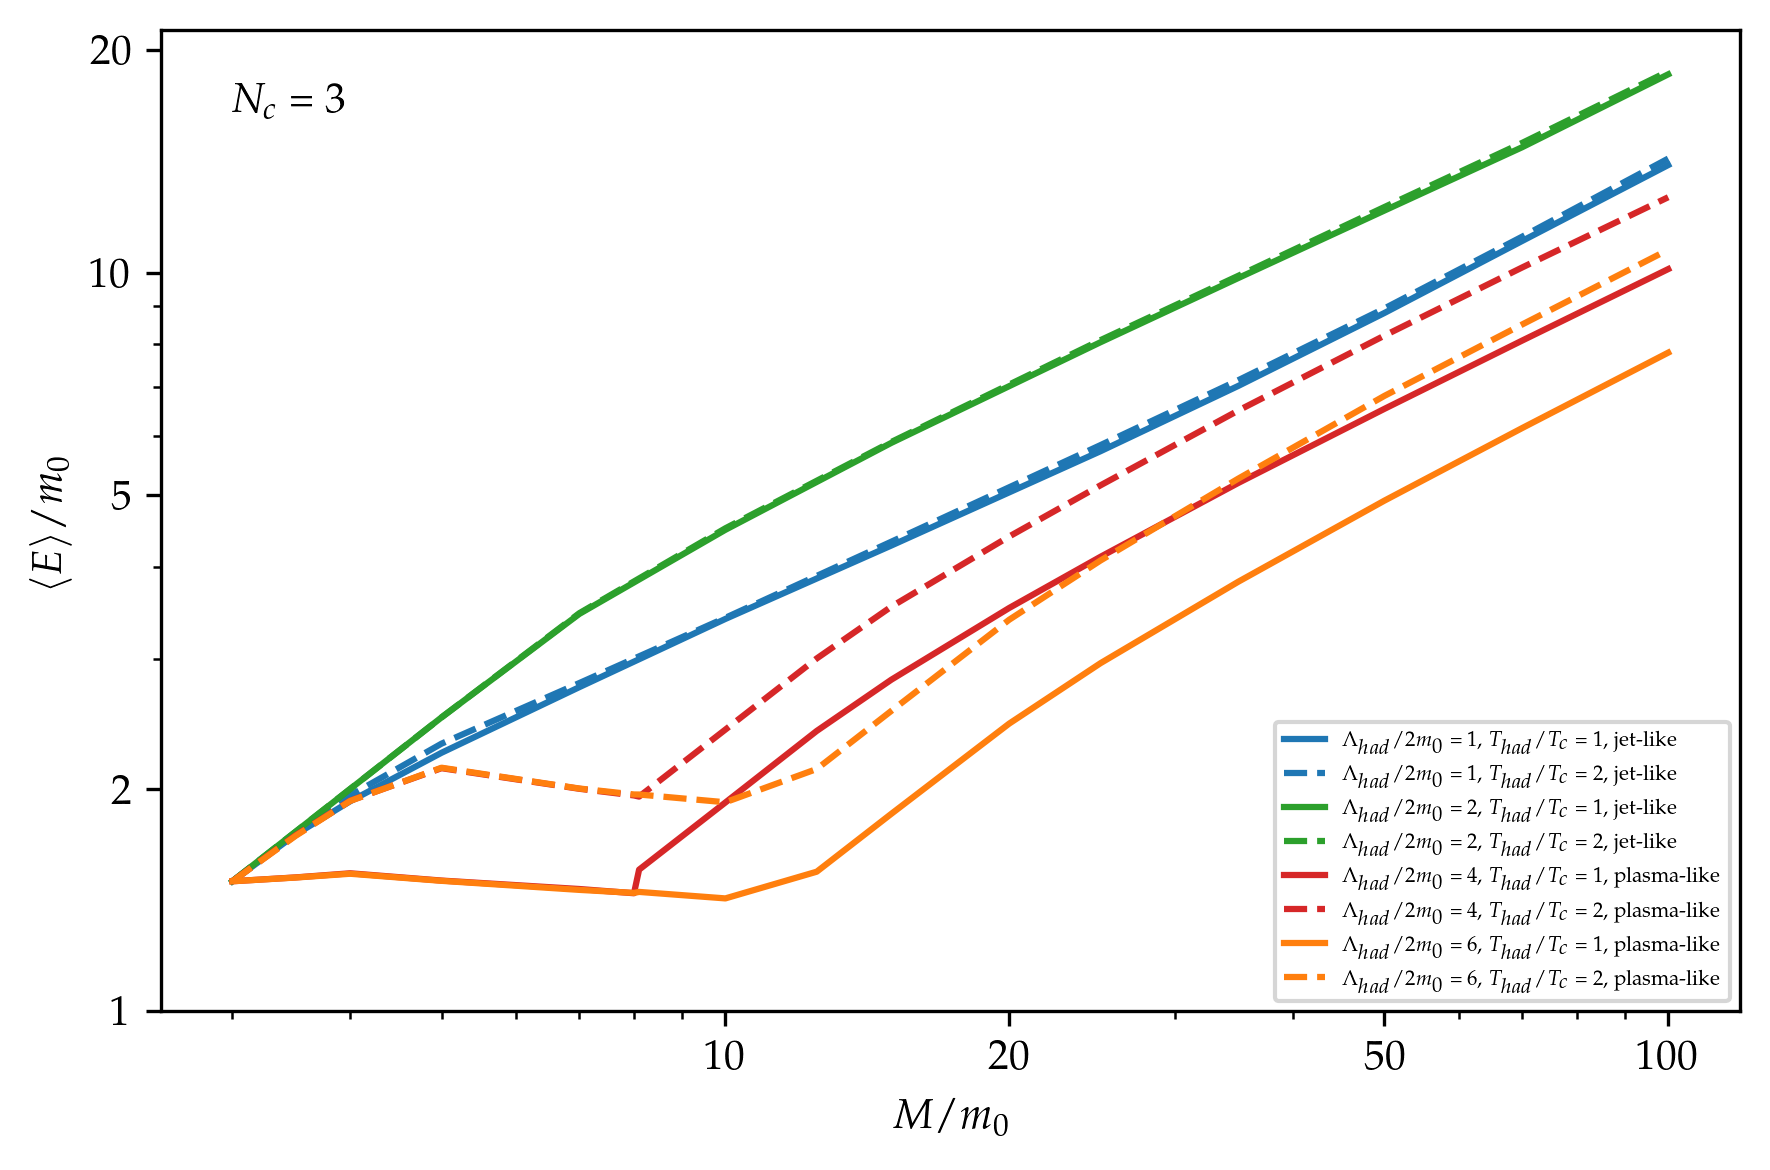

In [23]:
fig, ax = plt.subplots(figsize=(6,4),dpi=300)

ax.plot(M0_range/m0, avgE_N3_c1_d1/m0,label = "$\Lambda_{had}/2m_0$ = 1, $T_{had}/T_c$ = 1, jet-like", color = "tab:blue")
ax.plot(M0_range/m0, avgE_N3_c1_d2/m0,label = "$\Lambda_{had}/2m_0$ = 1, $T_{had}/T_c$ = 2, jet-like", color = "tab:blue",
        linestyle = 'dashed')

ax.plot(M0_range/m0, avgE_N3_c2_d1/m0,label = "$\Lambda_{had}/2m_0$ = 2, $T_{had}/T_c$ = 1, jet-like", color = "tab:green")
ax.plot(M0_range/m0, avgE_N3_c2_d2/m0,label = "$\Lambda_{had}/2m_0$ = 2, $T_{had}/T_c$ = 2, jet-like", color = "tab:green",
        linestyle = 'dashed')

ax.plot(M0_range_plasma/m0, avgE_N3_c4_d1_plasma/m0,label = "$\Lambda_{had}/2m_0$ = 4, $T_{had}/T_c$ = 1, plasma-like", color = "tab:red")
ax.plot(M0_range_plasma/m0, avgE_N3_c4_d2_plasma/m0,label = "$\Lambda_{had}/2m_0$ = 4, $T_{had}/T_c$ = 2, plasma-like", color = "tab:red",
        linestyle = 'dashed')

ax.plot(M0_range_plasma/m0, avgE_N3_c6_d1_plasma/m0,label = "$\Lambda_{had}/2m_0$ = 6, $T_{had}/T_c$ = 1, plasma-like", color = "tab:orange")
ax.plot(M0_range_plasma/m0, avgE_N3_c6_d2_plasma/m0,label = "$\Lambda_{had}/2m_0$ = 6, $T_{had}/T_c$ = 2, plasma-like", color = "tab:orange",
        linestyle = 'dashed')

#ax.set_title("Average Glueball Energy")
ax.legend(loc='lower right', prop={'size': 5})
ax.set_ylabel("$\langle E \\rangle / m_0 $")
ax.set_xlabel('$M / m_0$')
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(xmin=5, xmax=100)
#ax.set_ylim(ymin=9, ymax=300)

ax.text(3, 16.5, '$N_c$ = 3', fontsize = 10)

ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False)) # get rid of ridiculous offset
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False)) # get rid of ridiculous offset

ax.set_xticks([10,20,50,100])
ax.set_yticks([1,2,5,10,20])
plt.setp(ax.get_yminorticklabels(), visible=False)

fig.patch.set_facecolor('white')
fig.tight_layout()

plt.savefig('plots/benchmark_energy.pdf',bbox_inches='tight')

In [24]:
avgE_0pp_N3_c1_d1 = np.array([ average_E_0pp(i,10,3,1,1,False)[0] for i in M0_range ])
avgE_0pp_N3_c1_d2 = np.array([ average_E_0pp(i,10,3,1,2,False)[0] for i in M0_range ])

avgE_0pp_N3_c2_d1 = np.array([ average_E_0pp(i,10,3,2,1,False)[0] for i in M0_range ])
avgE_0pp_N3_c2_d2 = np.array([ average_E_0pp(i,10,3,2,2,False)[0] for i in M0_range ])

avgE_0pp_N3_c4_d1_plasma = np.array([ average_E_0pp(i,10,3,4,1,True)[0] for i in M0_range_plasma ])
avgE_0pp_N3_c4_d2_plasma = np.array([ average_E_0pp(i,10,3,4,2,True)[0] for i in M0_range_plasma ])

avgE_0pp_N3_c6_d1_plasma = np.array([ average_E_0pp(i,10,3,6,1,True)[0] for i in M0_range_plasma ])
avgE_0pp_N3_c6_d2_plasma = np.array([ average_E_0pp(i,10,3,6,2,True)[0] for i in M0_range_plasma ])

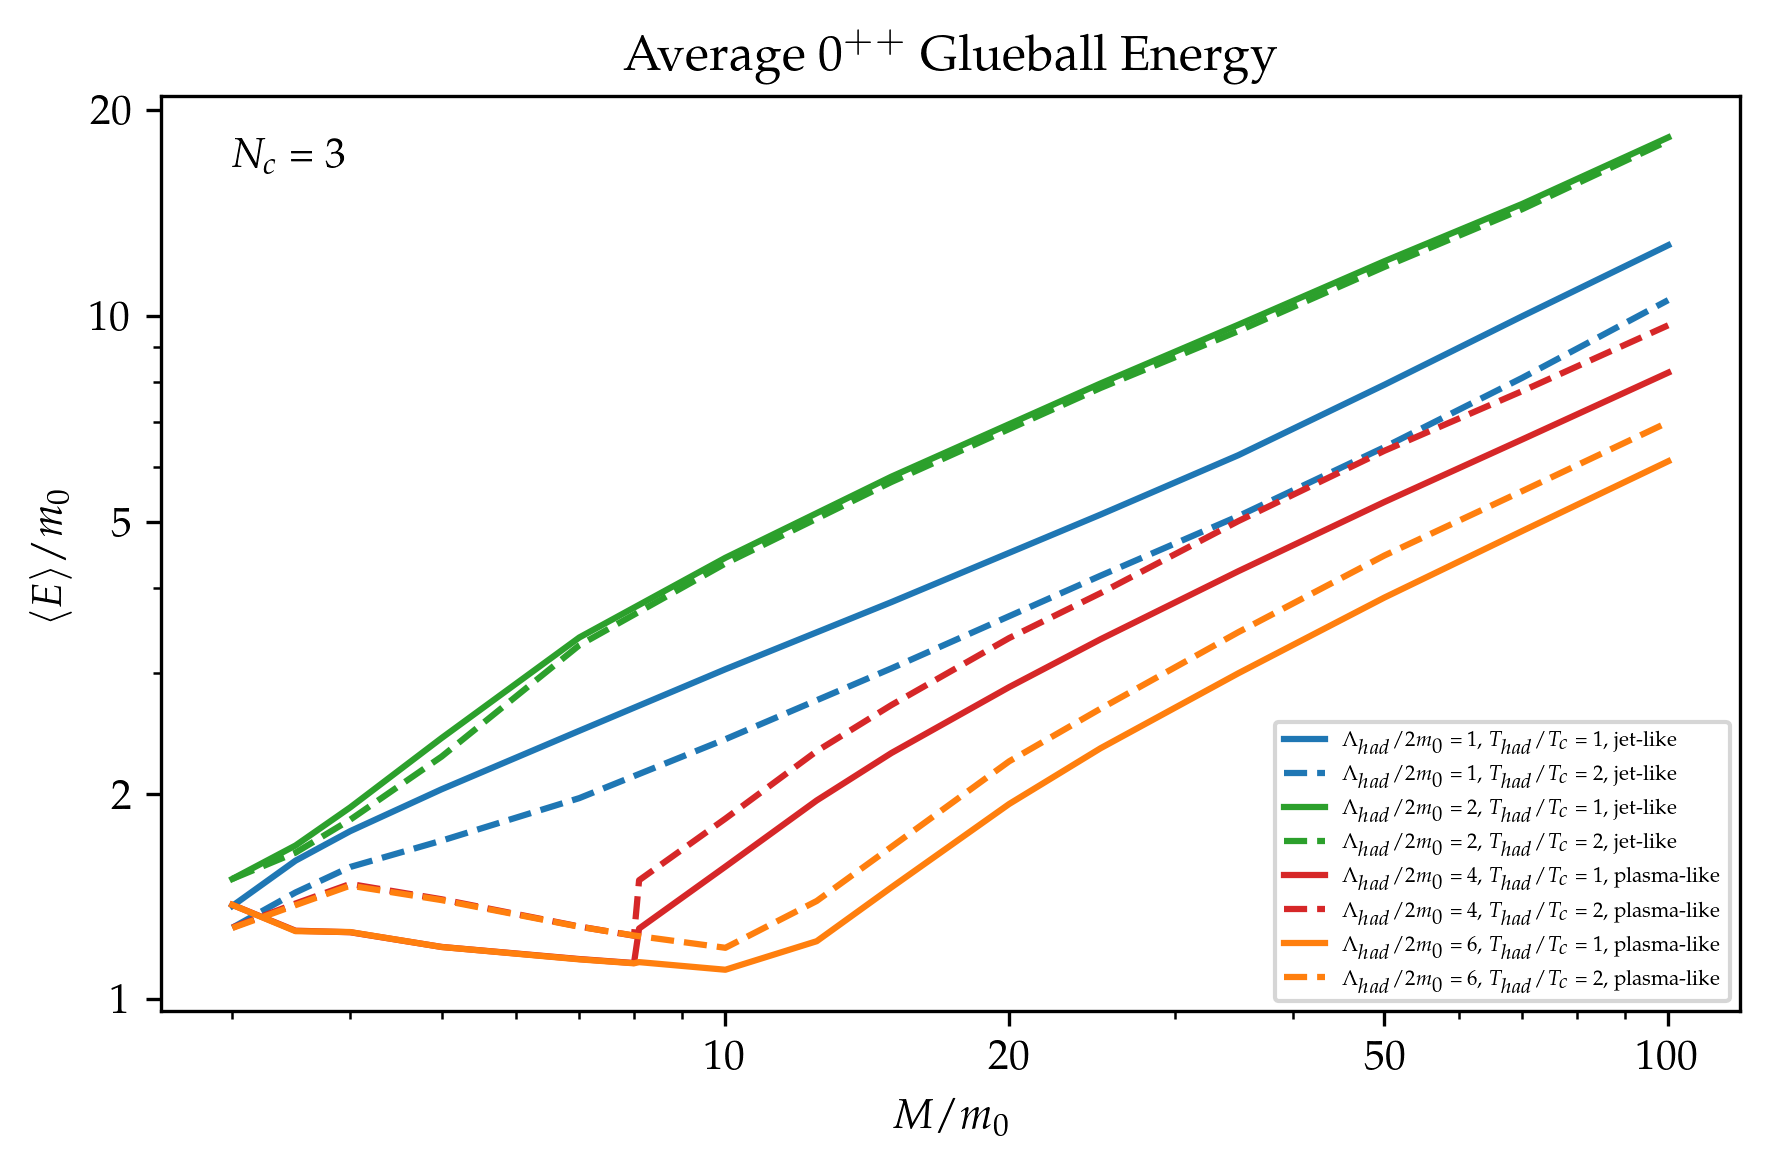

In [25]:
fig, ax = plt.subplots(figsize=(6,4),dpi=300)

ax.plot(M0_range/m0, avgE_0pp_N3_c1_d1/m0,label = "$\Lambda_{had}/2m_0$ = 1, $T_{had}/T_c$ = 1, jet-like", color = "tab:blue")
ax.plot(M0_range/m0, avgE_0pp_N3_c1_d2/m0,label = "$\Lambda_{had}/2m_0$ = 1, $T_{had}/T_c$ = 2, jet-like", color = "tab:blue",
        linestyle = 'dashed')

ax.plot(M0_range/m0, avgE_0pp_N3_c2_d1/m0,label = "$\Lambda_{had}/2m_0$ = 2, $T_{had}/T_c$ = 1, jet-like", color = "tab:green")
ax.plot(M0_range/m0, avgE_0pp_N3_c2_d2/m0,label = "$\Lambda_{had}/2m_0$ = 2, $T_{had}/T_c$ = 2, jet-like", color = "tab:green",
        linestyle = 'dashed')

ax.plot(M0_range_plasma/m0, avgE_0pp_N3_c4_d1_plasma/m0,label = "$\Lambda_{had}/2m_0$ = 4, $T_{had}/T_c$ = 1, plasma-like", color = "tab:red")
ax.plot(M0_range_plasma/m0, avgE_0pp_N3_c4_d2_plasma/m0,label = "$\Lambda_{had}/2m_0$ = 4, $T_{had}/T_c$ = 2, plasma-like", color = "tab:red",
        linestyle = 'dashed')

ax.plot(M0_range_plasma/m0, avgE_0pp_N3_c6_d1_plasma/m0,label = "$\Lambda_{had}/2m_0$ = 6, $T_{had}/T_c$ = 1, plasma-like", color = "tab:orange")
ax.plot(M0_range_plasma/m0, avgE_0pp_N3_c6_d2_plasma/m0,label = "$\Lambda_{had}/2m_0$ = 6, $T_{had}/T_c$ = 2, plasma-like", color = "tab:orange",
        linestyle = 'dashed')


ax.set_title("Average $0^{++}$ Glueball Energy")
ax.legend(loc='lower right', prop={'size': 5})
ax.set_ylabel("$\langle E \\rangle /m_0$")
ax.set_xlabel('$M / m_0$')
ax.set_xscale('log')
ax.set_yscale('log')

ax.text(3, 16.5, '$N_c$ = 3', fontsize = 10)

ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False)) # get rid of ridiculous offset
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False)) # get rid of ridiculous offset

ax.set_xticks([10,20,50,100])
ax.set_yticks([1,2,5,10, 20])
plt.setp(ax.get_yminorticklabels(), visible=False)

fig.patch.set_facecolor('white')
fig.tight_layout()

plt.savefig('plots/benchmark_energy_0pp.pdf',bbox_inches='tight')

# Fragmentation Functions

In [26]:
glueball_labels = ['$0^{++}$', '$2^{++}$', '$0^{-+}$', '$1^{+-}$', '$2^{-+}$', '$3^{+-}$', '$3^{++}$', '$1^{--}$',
                   '$2^{--}$', '$3^{--}$', '$2^{+-}$', '$0^{+-}$']

## Energy Spectra

In [27]:
def glueball_energy_FF_plots(M0,m0,N,c,d,plasma,num_events,num_glueballs=12):
    single_array = flatten_list_one_level([ only_final_states(item) for item in eventsM0m0cPlasma(M0,m0,N,c,d,plasma) ])

    list_of_spectra = [ [] for i in range(num_glueballs) ]
    
    for i in single_array:
        for j in range(num_glueballs):
            if i[1] == glueballs[j]:
                list_of_spectra[j].append(i[3][0])
                
    
    fig, ax = plt.subplots(figsize=(6,4),dpi=300)
    
    for i in range(num_glueballs):
        if list_of_spectra[i] != []:
            counts, bins = np.histogram(list_of_spectra[i], bins= 20, density = True)
            #print(len(list_of_spectra[i]))
            ax.hist(bins[:-1], bins, weights = (len(list_of_spectra[i])/num_events) *counts,
                    histtype = "step", label = glueball_labels[i] )
            
    if M0 % m0 == 0:
        scale = int(M0/m0)
    else:
        scale = M0/m0
            
    #ax.set_title("Glueball Energy Spectrum (Fragmentation Function)\n$M/m_0 = "+str(scale)+"$, $N_c$ = " + str(N) +
    #             ", $\Lambda_{had}/2m_0$ = " + str(c) + ", $T_{had}/T_c$ = " + str(d) + ", plasma-like = " + str(plasma) )
    ax.legend(loc='upper right', prop={'size': 6})
    ax.set_ylabel('dN/dE')
    ax.set_yscale('log')
    ax.set_xlabel('E (GeV)')
    #ax.set_xlim(xmin=yrs[0], xmax=yrs[-1])
    fig.patch.set_facecolor('white')
    
    c_label = str(c).replace('.','point')
    d_label = str(d).replace('.','point')
    
    plt.savefig('plots/fragmentation_functions/energy_spectrum_'+str(M0)+'GeV_'+str(m0)+'GeV_c'+str(c_label)+'_d'+str(d_label)+
                '_plasma_'+str(plasma)+'.pdf',bbox_inches='tight')
    
    return fig.tight_layout()

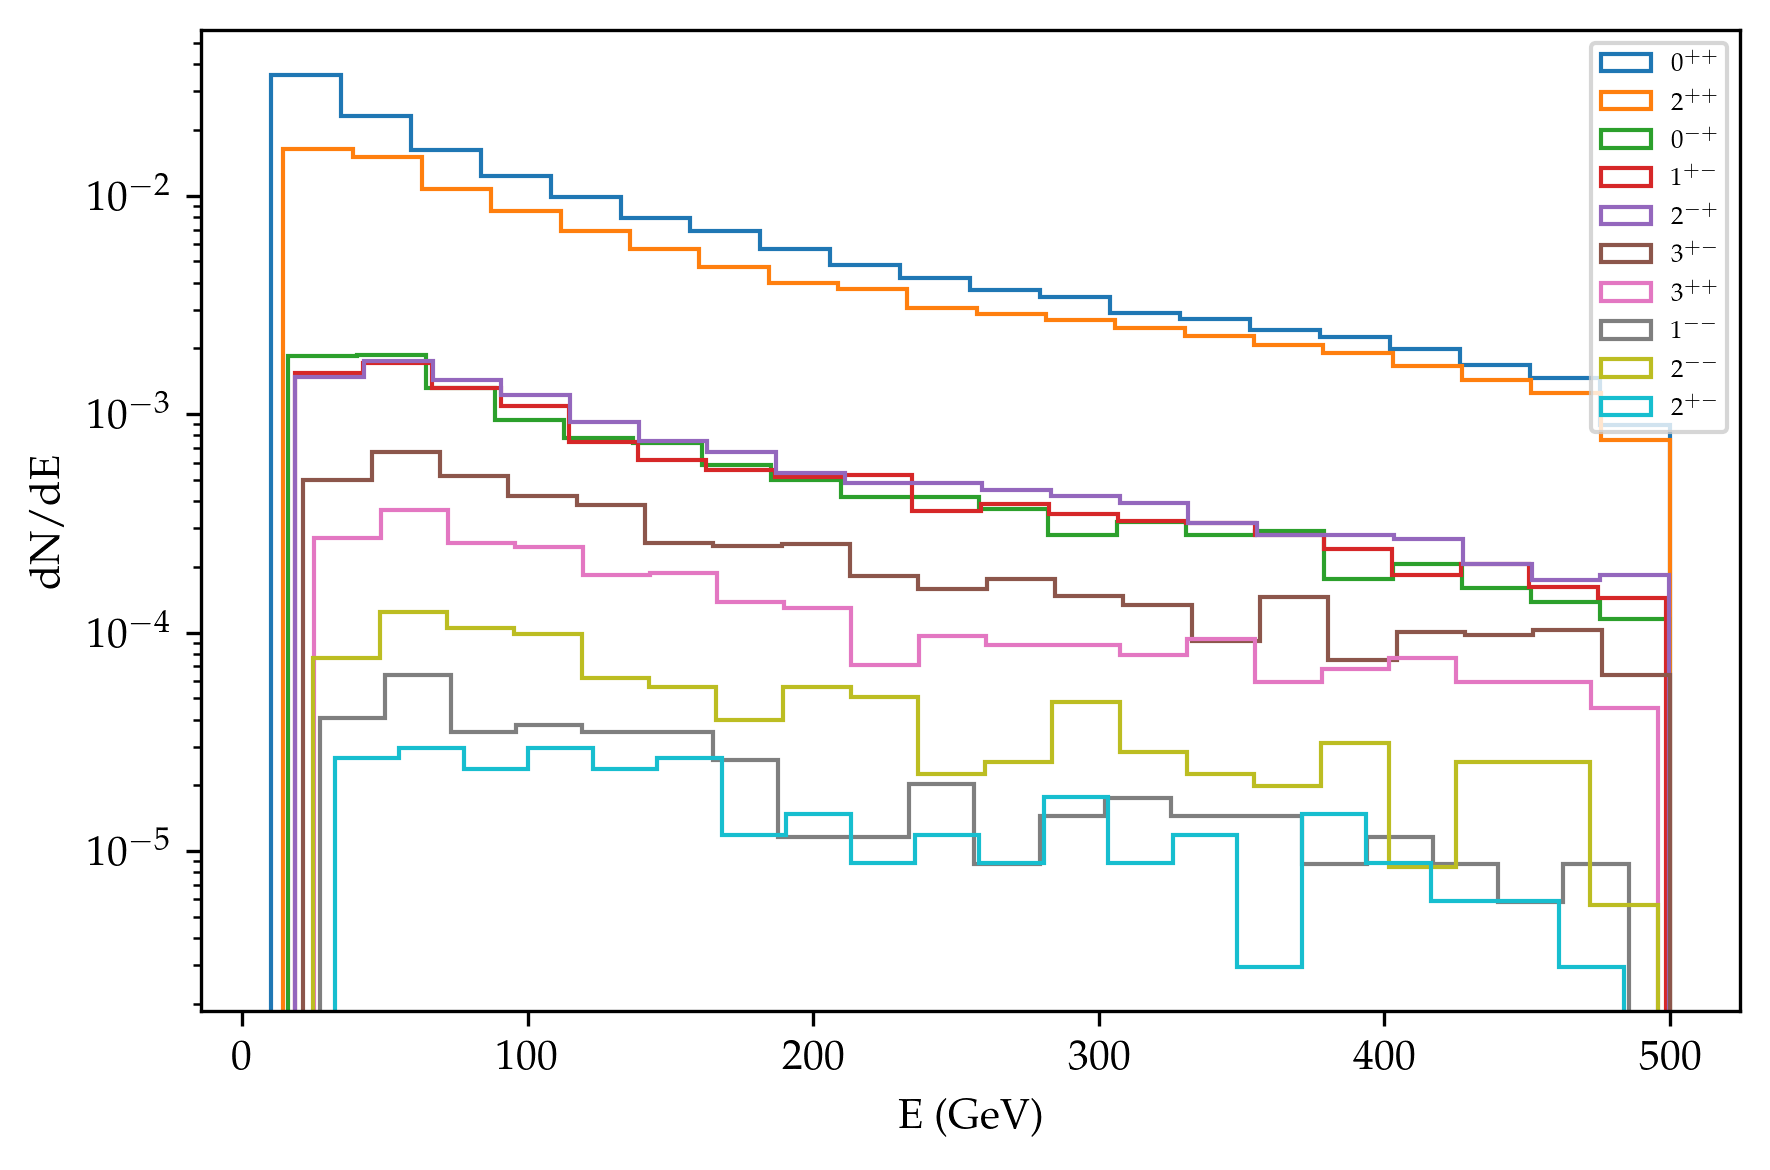

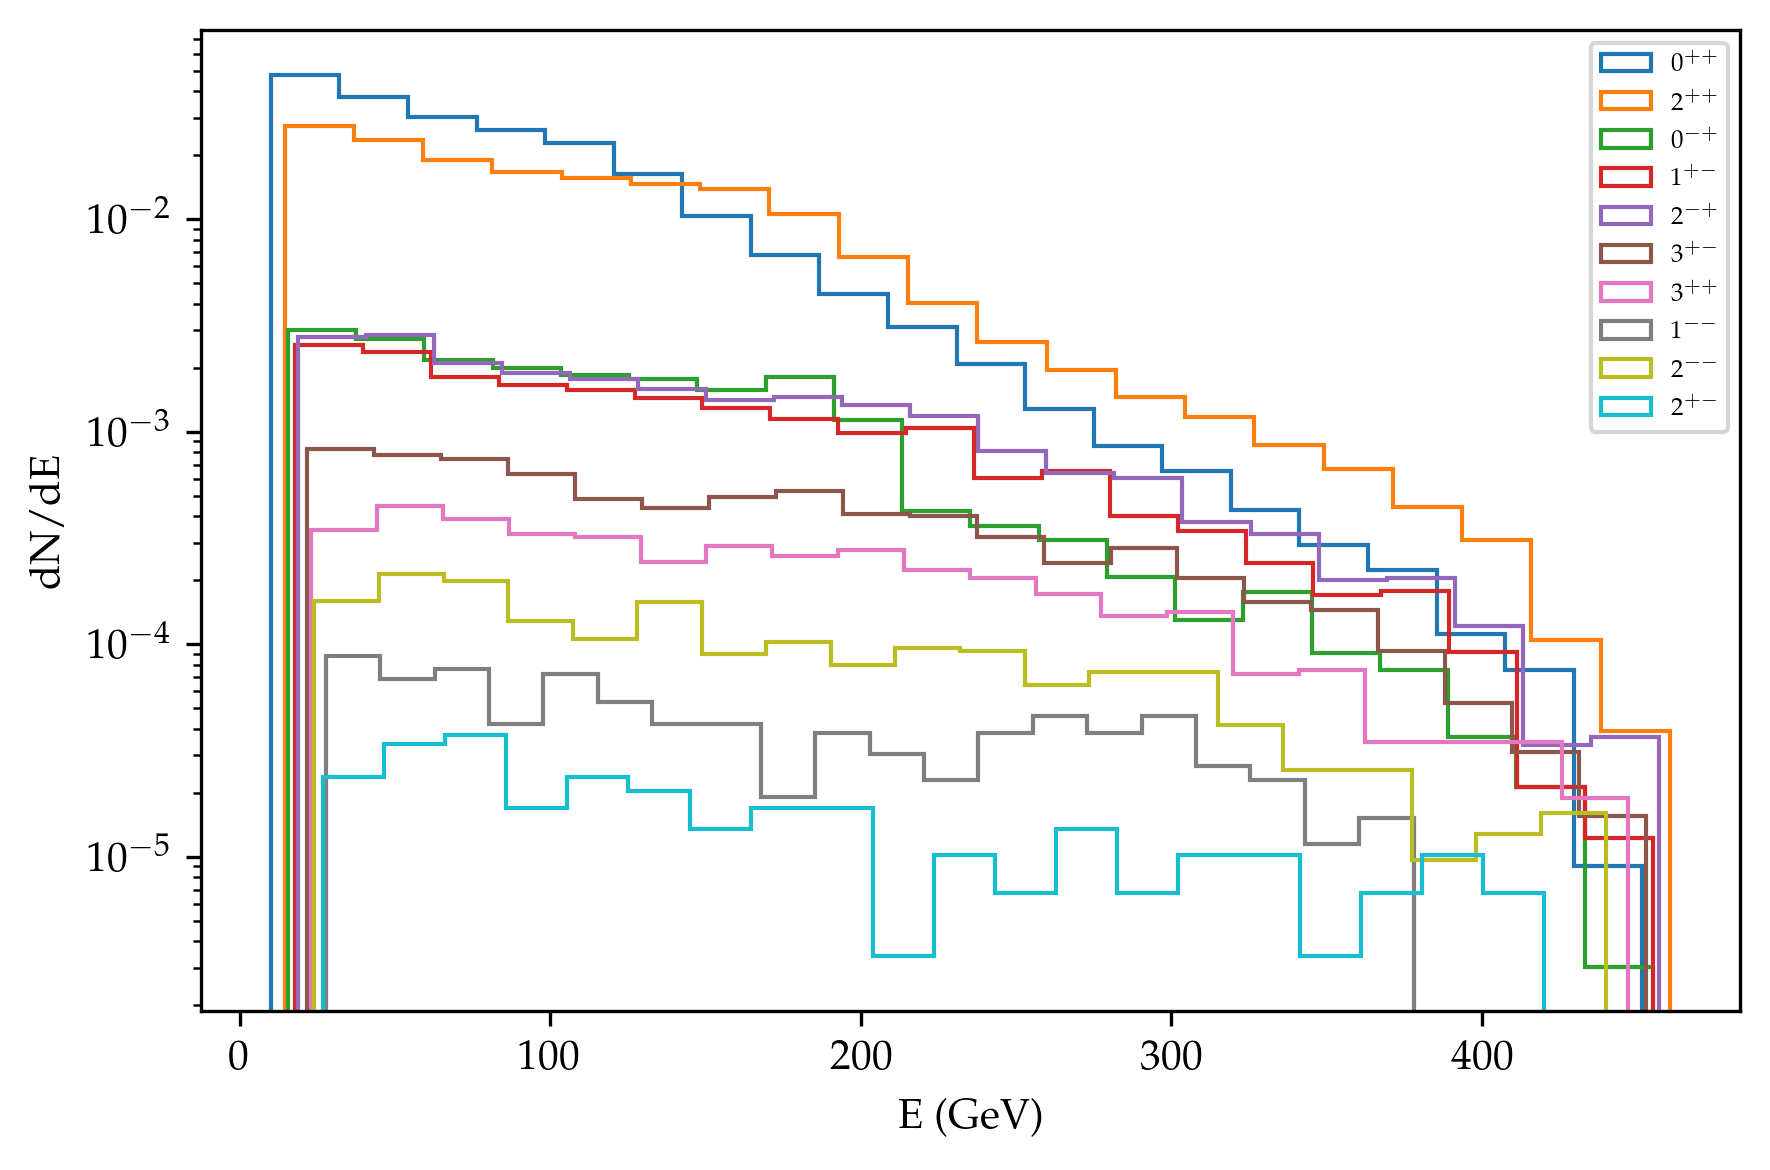

In [28]:
glueball_energy_FF_plots(1000,10,3,1,1,False,15000)
glueball_energy_FF_plots(1000,10,3,4,1,True,15000)

In [29]:
def glueball_energy_FF(M0,m0,N,c,d,plasma,num_events,glueball):
    single_array = flatten_list_one_level([ only_final_states(item) for item in eventsM0m0cPlasma(M0,m0,N,c,d,plasma) ])

    list_of_spectra = [ [] for i in range(len(glueballs)) ]
    
    for i in single_array:
        for j in range(len(glueballs)):
            if i[1] == glueballs[j]:
                list_of_spectra[j].append(i[3][0])
    
    index = list(glueballs).index(glueball)
    
    counts, bins = np.histogram(list_of_spectra[index], bins= 50, range = (m0,M0/2), density = True)
            
    return bins, (len(list_of_spectra[index])/num_events) * counts

In [30]:
def glueball_x_FF(M0,m0,N,c,d,plasma,num_events,glueball):
    single_array = flatten_list_one_level([ only_final_states(item) for item in eventsM0m0cPlasma(M0,m0,N,c,d,plasma) ])

    list_of_spectra = [ [] for i in range(len(glueballs)) ]
    
    for i in single_array:
        for j in range(len(glueballs)):
            if i[1] == glueballs[j]:
                list_of_spectra[j].append(i[3][0]/(0.5*M0))
    
    index = list(glueballs).index(glueball)
    
    counts, bins = np.histogram(list_of_spectra[index], bins= 50, range = (0,1), density = True)
            
    return bins, (len(list_of_spectra[index])/num_events) * counts

In [32]:
def plot_benchmark_FF(M0,glueball,num_events1,num_events2):
    hist1 = glueball_energy_FF(M0,10,3,1,1,False,num_events2,glueball)
    hist2 = glueball_energy_FF(M0,10,3,2,1,False,num_events1,glueball)
    hist3 = glueball_energy_FF(M0,10,3,4,1,True,num_events2,glueball)
    hist4 = glueball_energy_FF(M0,10,3,6,1,True,num_events1,glueball)
    hist5 = glueball_energy_FF(M0,10,3,1,2,False,num_events1,glueball)
    hist6 = glueball_energy_FF(M0,10,3,2,2,False,num_events1,glueball)
    hist7 = glueball_energy_FF(M0,10,3,4,2,True,num_events1,glueball)
    hist8 = glueball_energy_FF(M0,10,3,6,2,True,num_events1,glueball)

    fig, ax = plt.subplots(figsize=(12,8),dpi=300)
    output = ax.hist(hist1[0][:-1], hist1[0], weights = hist1[1], histtype = "step",label="$\Lambda_{had}/2m_0$ = 1, jet-like",
                     color = 'tab:blue');
    output = ax.hist(hist2[0][:-1], hist2[0], weights = hist2[1], histtype = "step",label="$\Lambda_{had}/2m_0$ = 2, jet-like",
                    color = 'tab:green');
    output = ax.hist(hist3[0][:-1], hist3[0], weights = hist3[1], histtype = "step",label="$\Lambda_{had}/2m_0$ = 4, plasma-like",
                    color = 'tab:red');
    output = ax.hist(hist4[0][:-1], hist4[0], weights = hist4[1], histtype = "step",label="$\Lambda_{had}/2m_0$ = 6, plasma-like",
                     color = 'tab:orange');
    output = ax.hist(hist1[0][:-1], hist5[0], weights = hist5[1], histtype = "step",label="$\Lambda_{had}/2m_0$ = 1, jet-like",
                     color = 'tab:blue',ls='--');
    output = ax.hist(hist2[0][:-1], hist6[0], weights = hist6[1], histtype = "step",label="$\Lambda_{had}/2m_0$ = 2, jet-like",
                    color = 'tab:green',ls='--');
    output = ax.hist(hist3[0][:-1], hist7[0], weights = hist7[1], histtype = "step",label="$\Lambda_{had}/2m_0$ = 4, plasma-like",
                    color = 'tab:red',ls='--')
    output = ax.hist(hist4[0][:-1], hist8[0], weights = hist8[1], histtype = "step",label="$\Lambda_{had}/2m_0$ = 6, plasma-like",
                     color = 'tab:orange',ls='--');

    ax.set_title("$0^{++}$ Glueball Energy Spectrum\n$M/m_0$ = "+str(int(M0/10))+", $N_c$ = 3, $T_{had}/T_c$ = 1")
    ax.legend(loc='upper right', prop={'size': 10})
    ax.set_ylabel('dN/dE')
    ax.set_xlabel('E (GeV)')
    ax.set_yscale('log')
    #ax.set_xlim(xmin=yrs[0], xmax=yrs[-1])
    fig.patch.set_facecolor('white')
    fig.tight_layout()

    plt.savefig('plots/0pp_FF_'+str(M0)+'GeV.pdf',bbox_inches='tight')

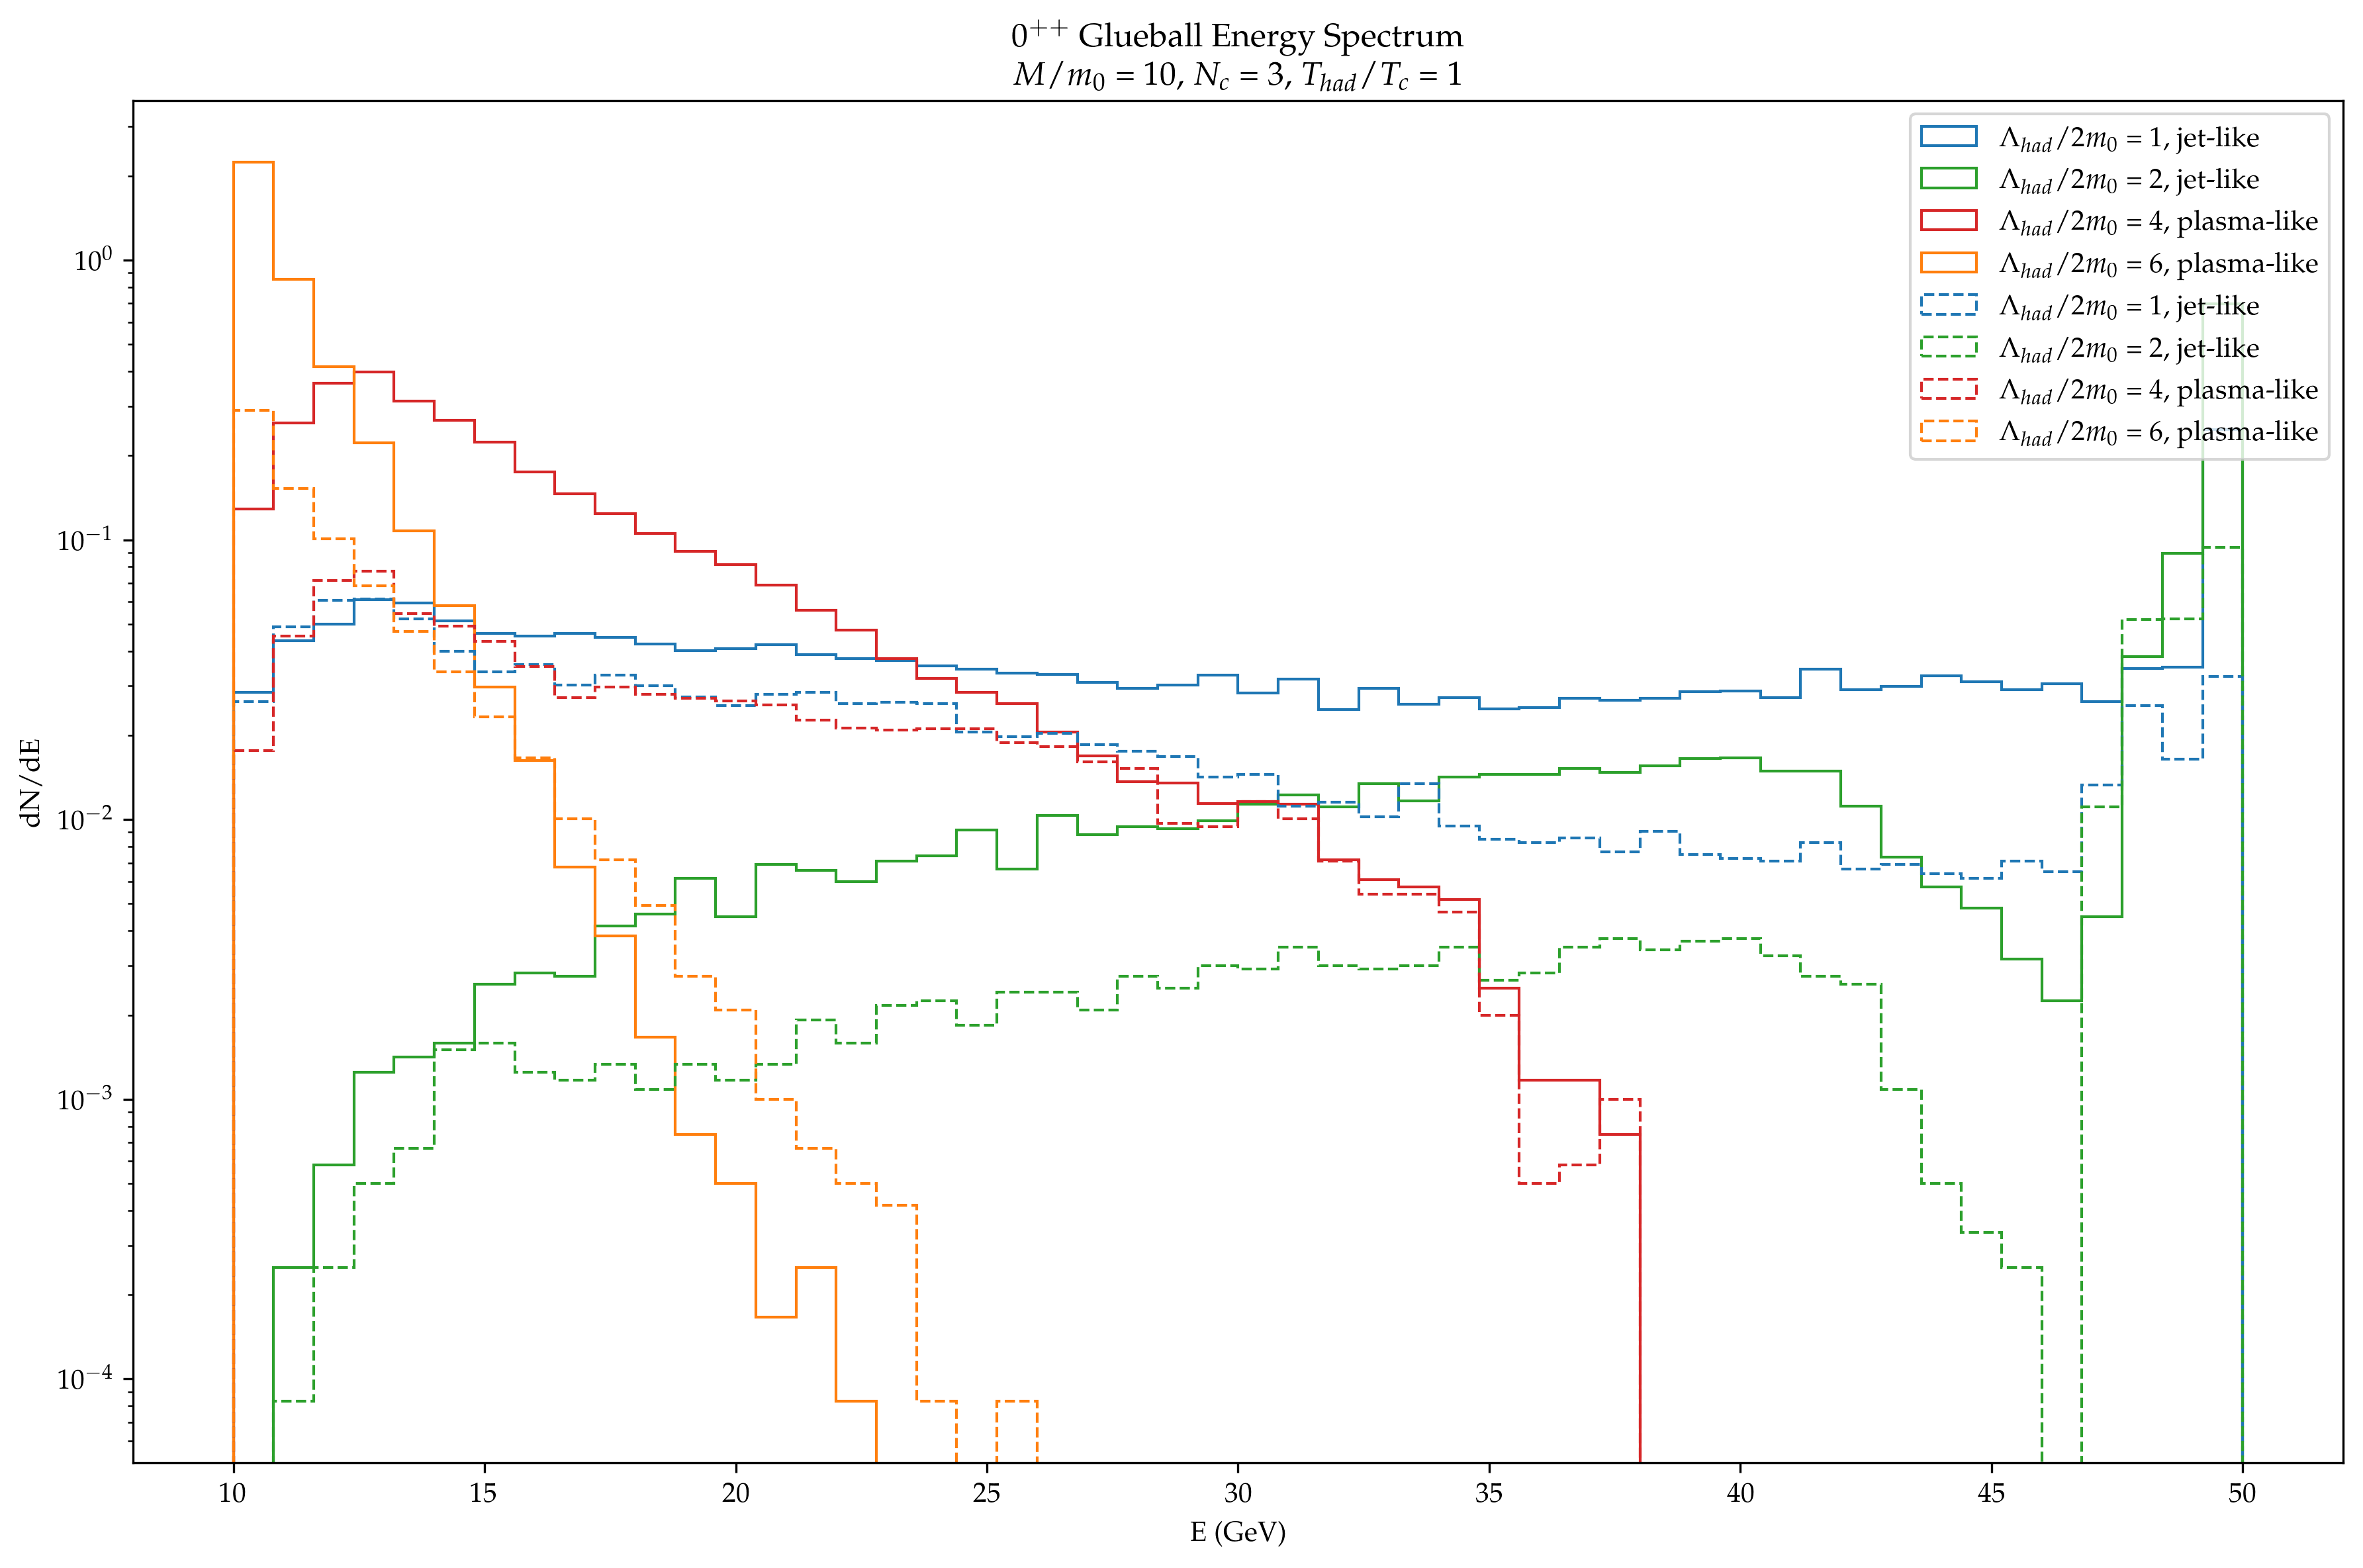

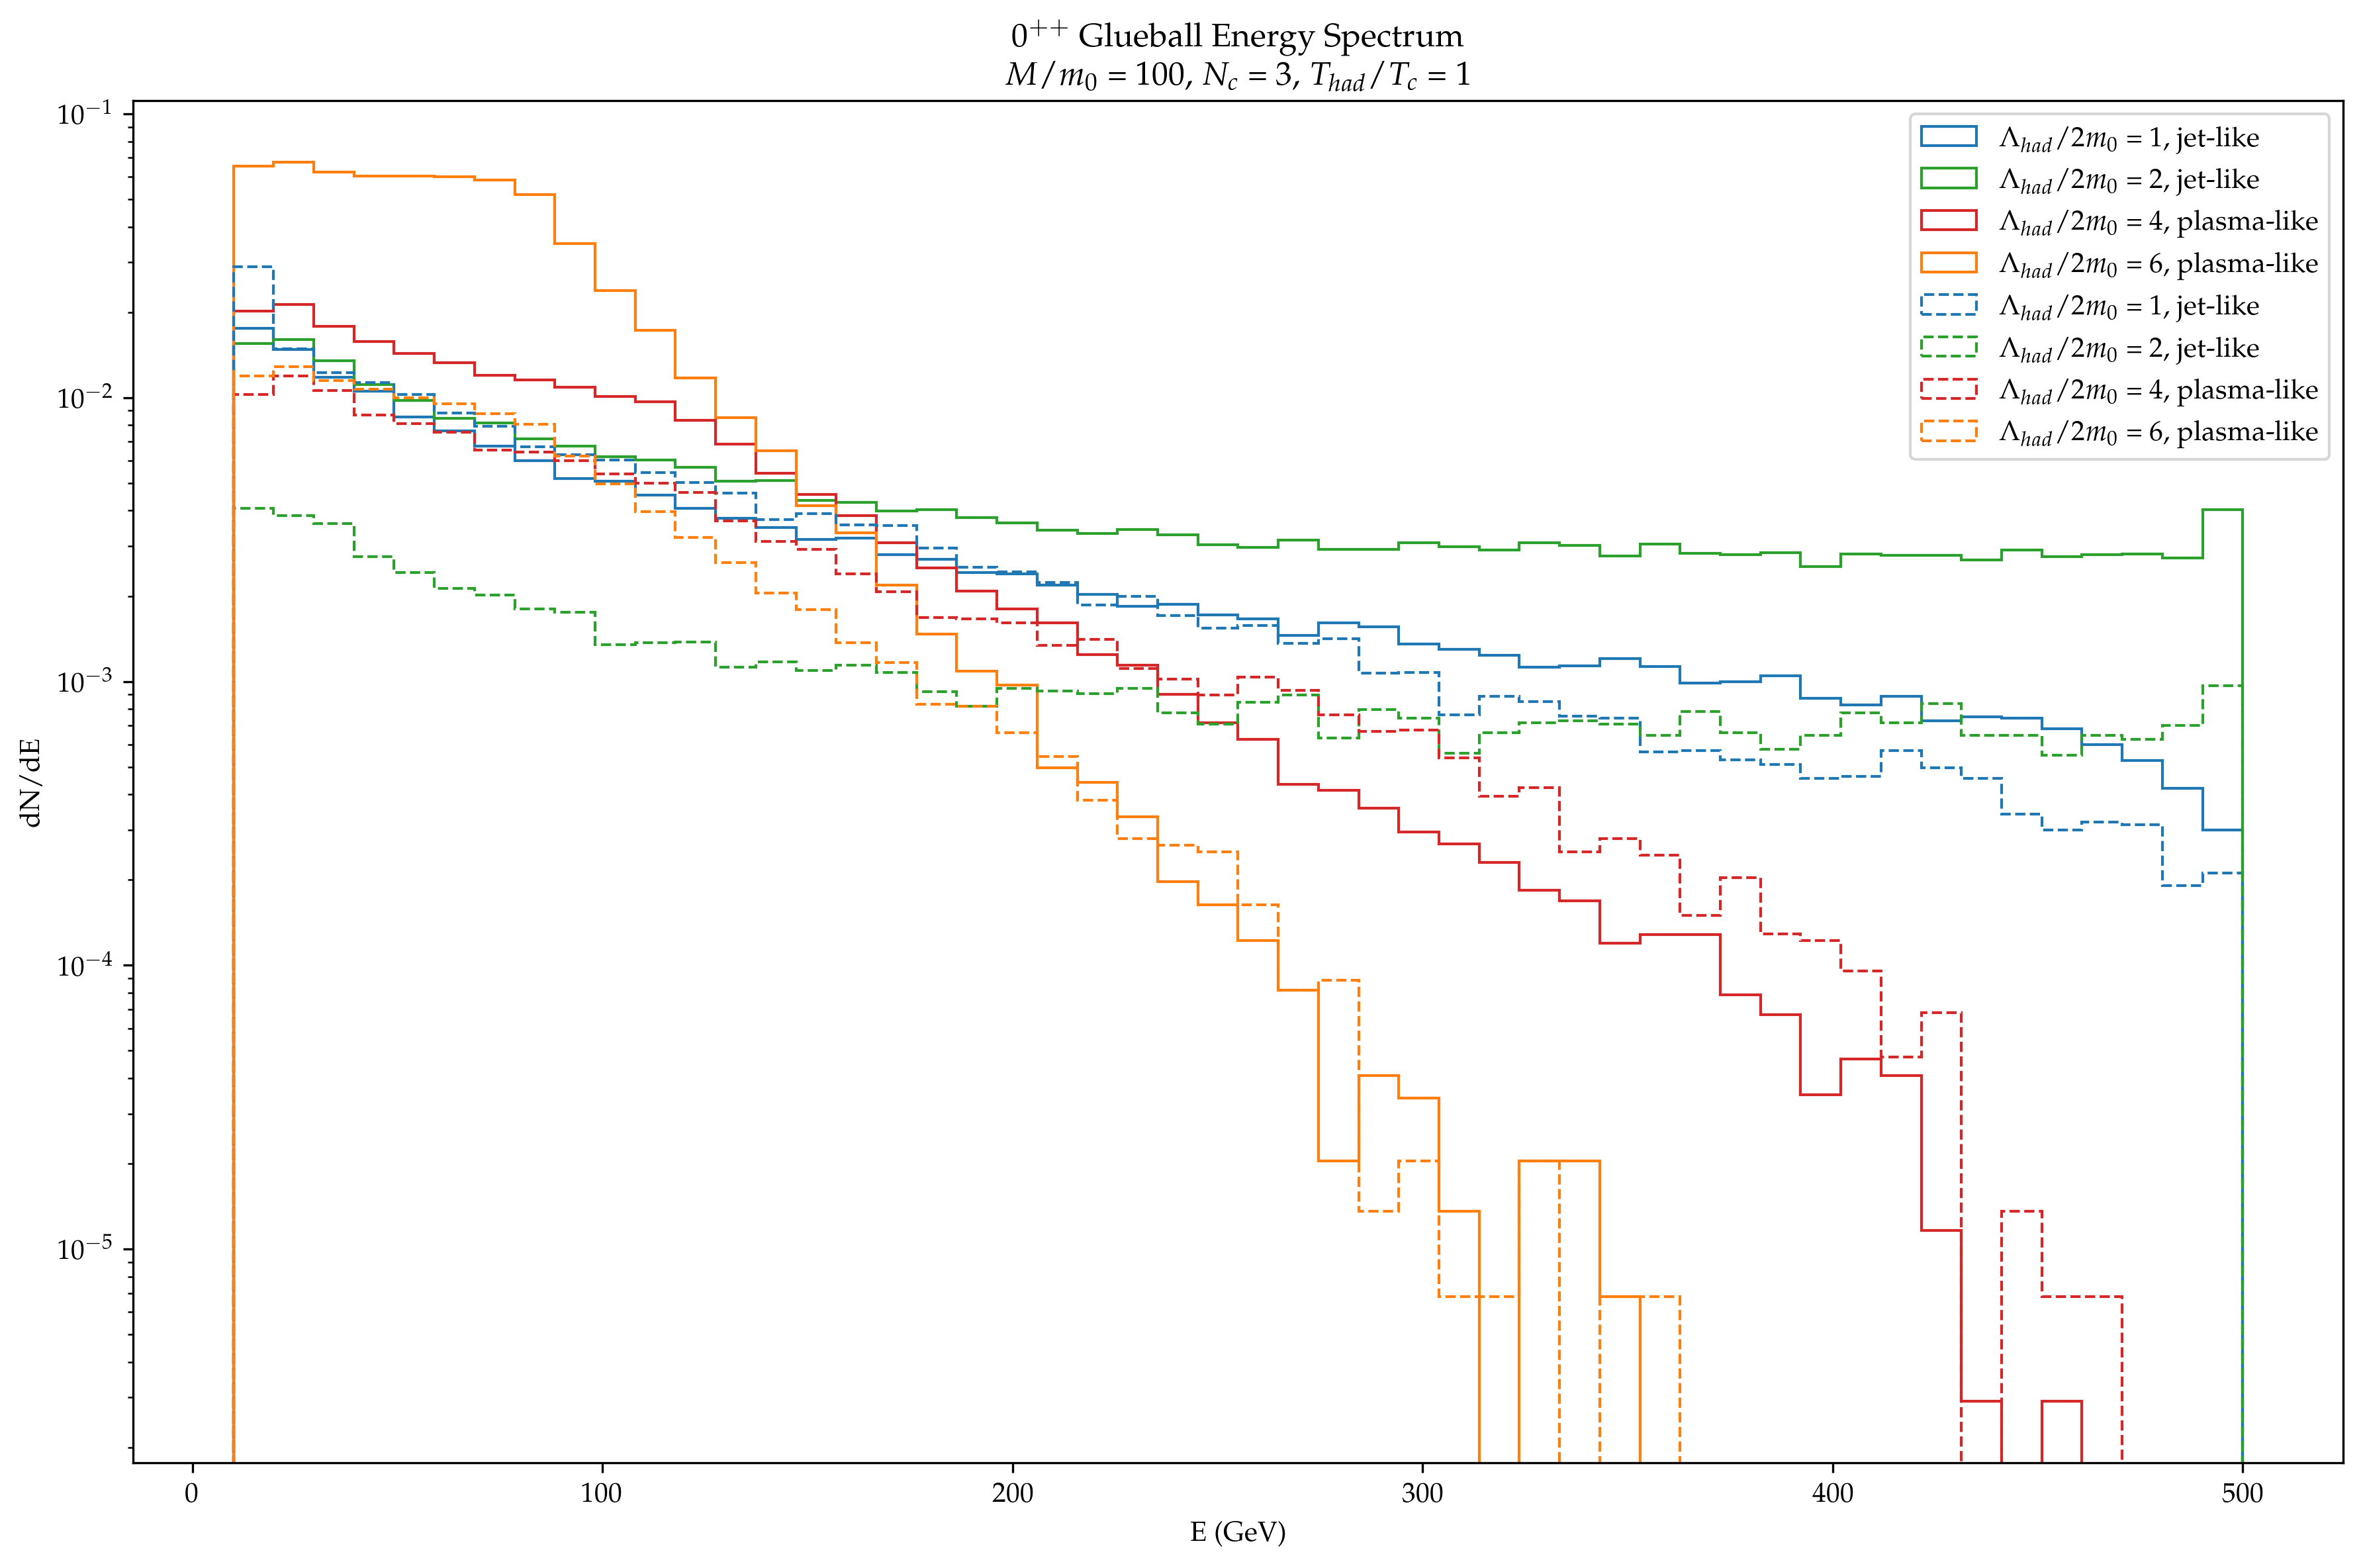

In [33]:
plot_benchmark_FF(100,'0++',15000,15000)
plot_benchmark_FF(1000,'0++',15000,35000)

## High - x fit comparison

In [34]:
# Colangelo and Nason function (see Eq. (19.17) in https://pdg.lbl.gov/2019/reviews/rpp2019-rev-frag-functions.pdf)

def highx_fit(x,Norm,a,b):
    return Norm*(x**a)*(1-x)**b

highx_vec = np.vectorize(highx_fit)

In [35]:
def plot_highx_fit(M0,m0,N,c,d,plasma,num_events,glueball):
    single_array = flatten_list_one_level([ only_final_states(item) for item in eventsM0m0cPlasma(M0,m0,N,c,d,plasma) ])

    list_of_spectra = [ [] for i in range(len(glueballs)) ]
    
    for i in single_array:
        for j in range(len(glueballs)):
            if i[1] == glueballs[j]:
                list_of_spectra[j].append(i[3][0])
    
    index = list(glueballs).index(glueball)
    
    listofxenergy = 2*np.array(list_of_spectra[index])/M0
    
    counts, bins = np.histogram(listofxenergy, bins= 50, density = True)
    
    bins_midpoints = [ 0.5*(bins[i+1] + bins[i]) for i in range(len(bins) - 1) ]
    
    weighted_counts = (len(list_of_spectra[index])/num_events) * counts
    
    bins_midpoints_range = [ bins_midpoints[i] for i in range(len(bins_midpoints)) if 0.1 < bins_midpoints[i] ]
    weighted_counts_range = [ weighted_counts[i] for i in range(len(weighted_counts)) if 0.1 < bins_midpoints[i] ]
    
    params = curve_fit(highx_fit, bins_midpoints_range, weighted_counts_range,)[0]
    
    print(params)
    
    fit = highx_vec(bins_midpoints_range,params[0],params[1],params[2])
    
    
    fig, ax = plt.subplots(figsize=(6,4),dpi=300)
    
    ax.hist(bins[:-1], bins, weights = weighted_counts, histtype = "step", label = glueball_labels[index],
            color='tab:blue' )
    ax.plot(bins_midpoints_range,fit,'r--',label='Fitting Function')
    
    if M0 % m0 == 0:
        scale = int(M0/m0)
    else:
        scale = M0/m0
            
    ax.set_title("Glueball Energy Spectrum Fit Comparison\n$M/m_0 = "+str(scale)+"$, $N_c$ = " + str(N) +
                 ", $\Lambda_{had}/2m_0$ = " + str(c) + ", $T_{had}/T_c$ = " + str(d) + ", plasma-like = " + str(plasma) )
    ax.legend(loc='upper right', prop={'size': 8})
    ax.set_ylabel('dN/dx')
    ax.set_xlabel('x')
    #ax.set_xlim( xmin = 0.1, xmax = 0.95 )
    fig.patch.set_facecolor('white')
    
    c_label = str(c).replace('.','point')
    d_label = str(d).replace('.','point')
    
    #plt.savefig('plots/fragmentation_function_fits/fit_'+str(M0)+'GeV_'+str(m0)+'GeV_c'+str(c_label)+'_d'+str(d_label)+
    #            '_plasma_'+str(plasma)+'.pdf',bbox_inches='tight')
    
    

[ 0.64514035 -0.79123425  0.24509993]


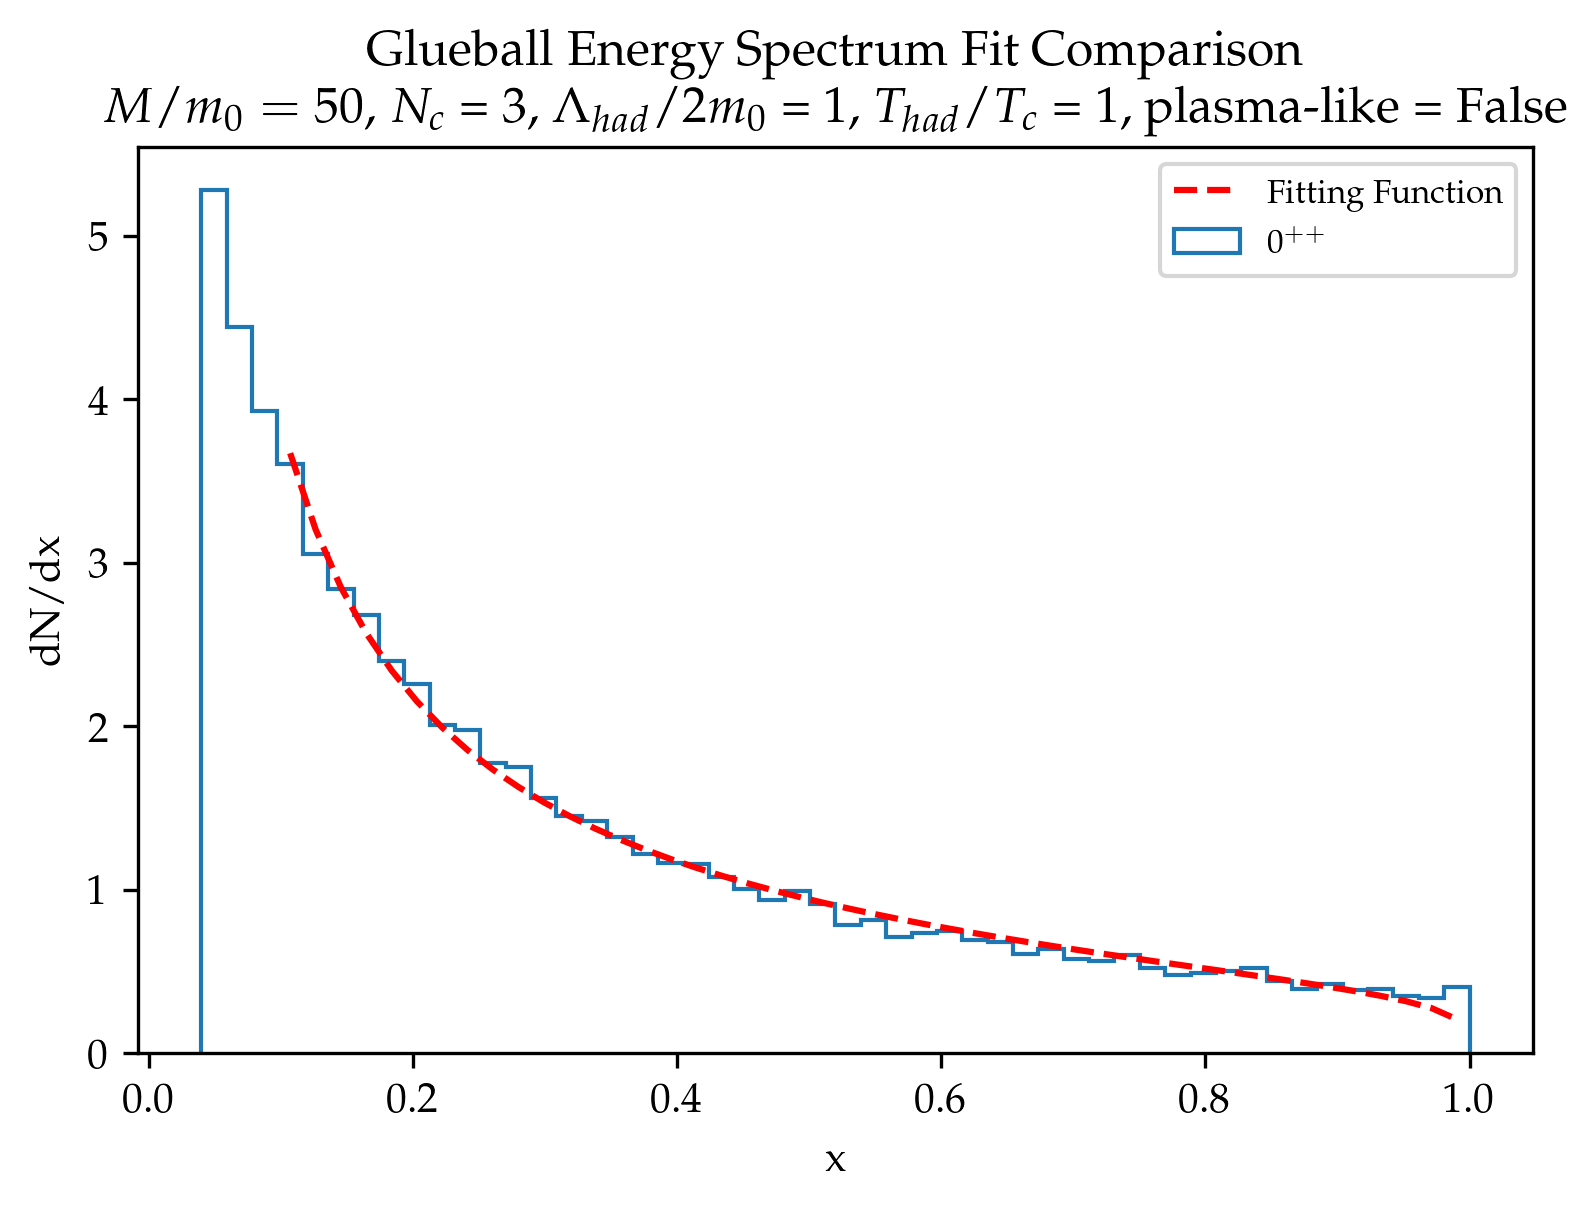

In [36]:
M0 = 500
glueball = '0++'

plot_highx_fit(M0,10,3,1,1,False,35000,glueball)

In [37]:
def get_frag_bins(M0,m0,N,c,d,plasma,num_events,glueball):
    single_array = flatten_list_one_level([ only_final_states(item) for item in eventsM0m0cPlasma(M0,m0,N,c,d,plasma) ])

    list_of_spectra = [ [] for i in range(len(glueballs)) ]
    
    for i in single_array:
        for j in range(len(glueballs)):
            if i[1] == glueballs[j]:
                list_of_spectra[j].append(i[3][0])
    
    index = list(glueballs).index(glueball)
    
    listofxenergy = 2*np.array(list_of_spectra[index])/M0
    
    counts, bins = np.histogram(listofxenergy, bins= 50, density = True)
    
    bins_midpoints = [ 0.5*(bins[i+1] + bins[i]) for i in range(len(bins) - 1) ]
    
    weighted_counts = (len(list_of_spectra[index])/num_events) * counts
    
    return bins, weighted_counts

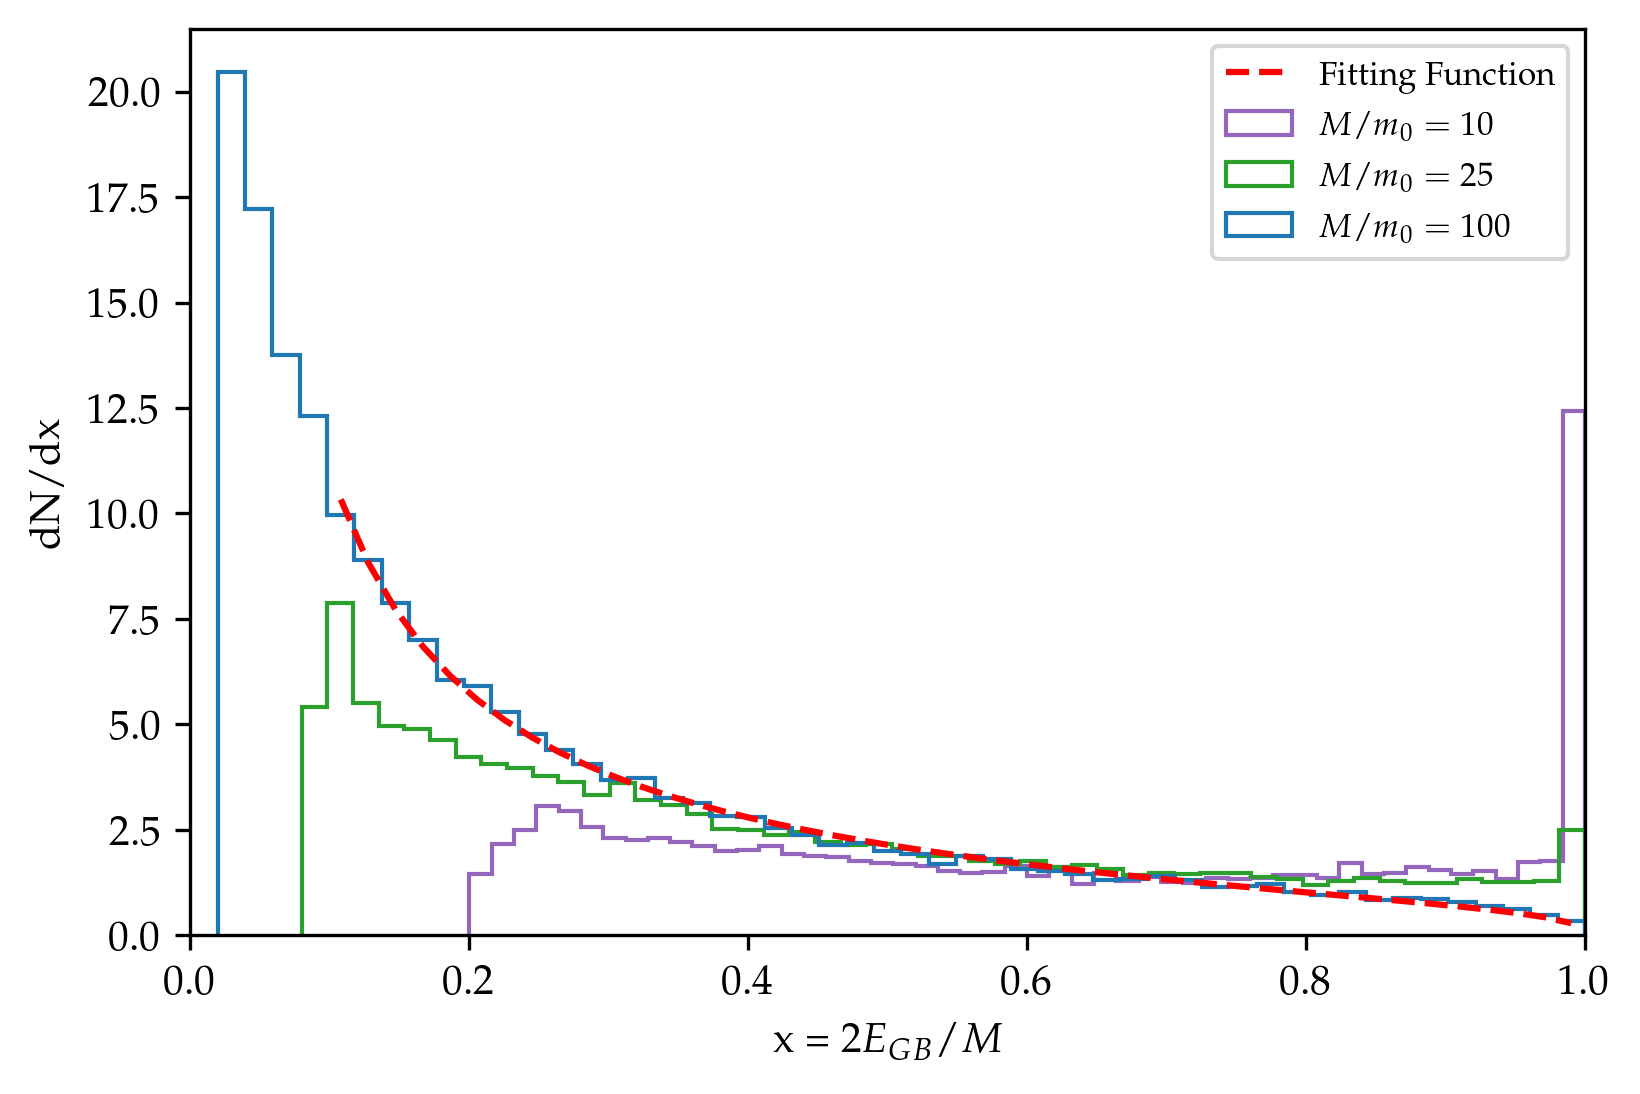

In [45]:
bins_100, counts_100 = get_frag_bins(100,10,3,1,1,False,15000,'0++')
bins_250, counts_250 = get_frag_bins(250,10,3,1,1,False,15000,'0++')
bins_1000, counts_1000 = get_frag_bins(1000,10,3,1,1,False,15000,'0++')

bins_midpoints = [ 0.5*(bins_1000[i+1] + bins_1000[i]) for i in range(len(bins_1000) - 1) ]
bins_midpoints_range = [ bins_midpoints[i] for i in range(len(bins_midpoints)) if 0.1 < bins_midpoints[i] ]
weighted_counts_range = [ counts_1000[i] for i in range(len(counts_1000)) if 0.1 < bins_midpoints[i] ]
params = curve_fit(highx_fit, bins_midpoints_range, weighted_counts_range,)[0]
fit = highx_vec(bins_midpoints_range,params[0],params[1],params[2])

fig, ax = plt.subplots(figsize=(6,4),dpi=300)
    
ax.hist(bins_100[:-1], bins_100, weights = counts_100, histtype = "step", label = '$M/m_0 = 10$',
        color='tab:purple' )
ax.hist(bins_250[:-1], bins_250, weights = counts_250, histtype = "step", label = '$M/m_0 = 25$',
        color='tab:green' ) 
ax.hist(bins_1000[:-1], bins_1000, weights = counts_1000, histtype = "step", label = '$M/m_0 = 100$',
        color='tab:blue' )
ax.plot(bins_midpoints_range,fit,'r--',label='Fitting Function')


#ax.set_title("$0^{++}$ Glueball Energy Spectrum\n$N_c$ = 3, $\Lambda_{had}/2m_0$ = 4, $T_{had}/T_c$ = 1, plasma-like = True")
ax.legend(loc='upper right', prop={'size': 8})
ax.set_ylabel('dN/dx')
ax.set_xlabel('x = $2E_{GB}/M$')
ax.set_xlim( xmin = 0, xmax = 1 )
fig.patch.set_facecolor('white')

plt.savefig('plots/fitting_function_comparison/fit_range.pdf',bbox_inches='tight')

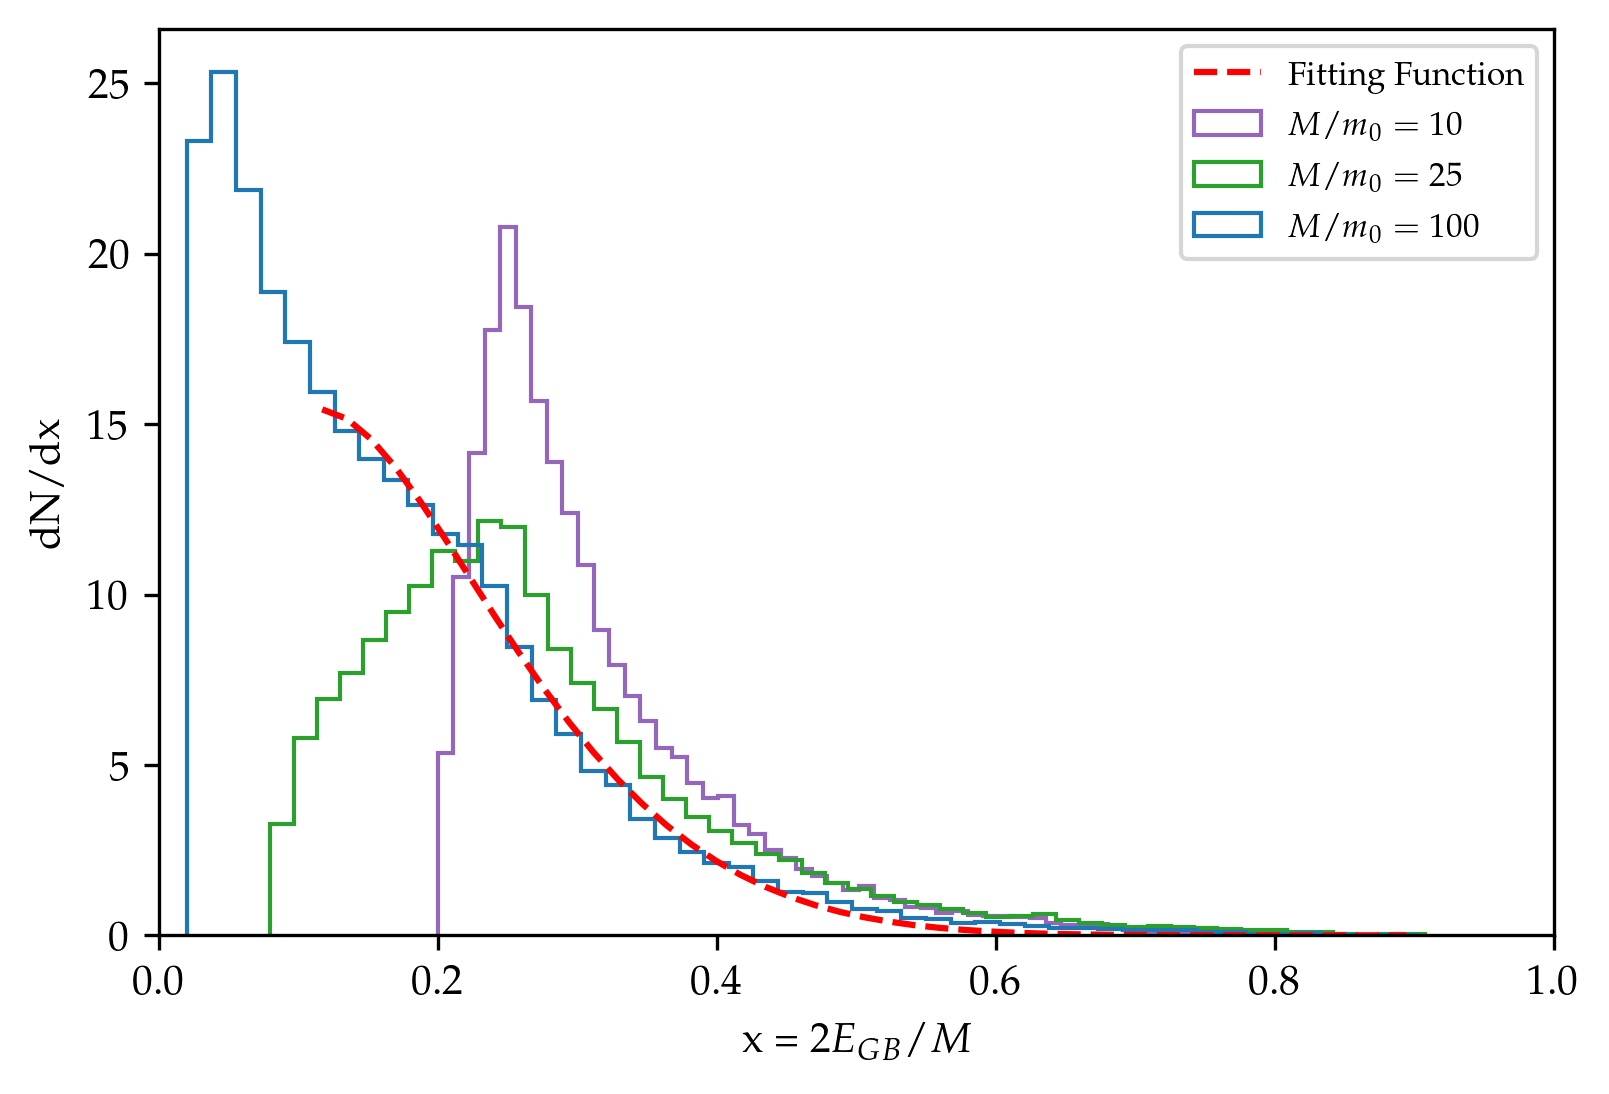

In [46]:
bins_100, counts_100 = get_frag_bins(100,10,3,4,1,True,15000,'0++')
bins_250, counts_250 = get_frag_bins(250,10,3,4,1,True,15000,'0++')
bins_1000, counts_1000 = get_frag_bins(1000,10,3,4,1,True,15000,'0++')

bins_midpoints = [ 0.5*(bins_1000[i+1] + bins_1000[i]) for i in range(len(bins_1000) - 1) ]
bins_midpoints_range = [ bins_midpoints[i] for i in range(len(bins_midpoints)) if 0.1 < bins_midpoints[i] ]
weighted_counts_range = [ counts_1000[i] for i in range(len(counts_1000)) if 0.1 < bins_midpoints[i] ]
params = curve_fit(highx_fit, bins_midpoints_range, weighted_counts_range,)[0]
fit = highx_vec(bins_midpoints_range,params[0],params[1],params[2])

fig, ax = plt.subplots(figsize=(6,4),dpi=300)
    
ax.hist(bins_100[:-1], bins_100, weights = counts_100, histtype = "step", label = '$M/m_0 = 10$',
        color='tab:purple' )
ax.hist(bins_250[:-1], bins_250, weights = counts_250, histtype = "step", label = '$M/m_0 = 25$',
        color='tab:green' ) 
ax.hist(bins_1000[:-1], bins_1000, weights = counts_1000, histtype = "step", label = '$M/m_0 = 100$',
        color='tab:blue' )
ax.plot(bins_midpoints_range,fit,'r--',label='Fitting Function')


#ax.set_title("$0^{++}$ Glueball Energy Spectrum\n$N_c$ = 3, $\Lambda_{had}/2m_0$ = 4, $T_{had}/T_c$ = 1, plasma-like = True")
ax.legend(loc='upper right', prop={'size': 8})
ax.set_ylabel('dN/dx')
ax.set_xlabel('x = $2E_{GB}/M$')
ax.set_xlim( xmin = 0, xmax = 1 )
fig.patch.set_facecolor('white')

plt.savefig('plots/fitting_function_comparison/fit_range_plasma.pdf',bbox_inches='tight')